## Data

We will use data from USA only

We use the 153 characteristics used by JKP

We will use Kenneth French's industry portfolios

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets
from datetime import datetime
import matplotlib.pyplot as plt
from utils_new import demarket, regcov, l2est
from cross_validate import cross_validate
import yfinance as yf

from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.model_selection import KFold
import warnings

warnings.filterwarnings("ignore")  # Ignorerer alle advarsler


import matplotlib.tri as tri


from sklearn.model_selection import train_test_split, GridSearchCV

data = pd.read_csv("C:/Users/ulrik/Downloads/[usa]_[all_factors]_[monthly]_[vw_cap].csv")

#Get unique values
unique_values = data.iloc[:, 1].unique()


data["date"] = pd.to_datetime(data["date"])
data = data[data["date"] >= "1980-01-01"]
data["date"] = data["date"].dt.strftime("%Y-%m")

data
ff_dict = FamaFrenchReader('10_Industry_Portfolios',
                           start='1980-01-01', 
                           end='2023-12-31').read()

ff_dict_returns = ff_dict[1] / 100
data_short = data[['name', 'date', 'ret']]

df = pd.DataFrame(data)


df['date'] = pd.to_datetime(df['date'])

df_wide = df.pivot(index='date', columns='name', values='ret')


SPX = data = pd.read_csv("C:/Users/ulrik/Downloads/S&P 500 Historical Data.csv")

SPX['Date'] = pd.to_datetime(SPX['Date'], format='%m/%d/%Y')  # Adjust format if needed

# Set 'Date' as index and keep only 'Change %' column
SPX = SPX.set_index('Date')[['Change %']]
SPX = SPX.iloc[::-1]

SPX['Change %'] = SPX['Change %'].str.rstrip('%').astype(float) / 100

from fredapi import Fred
import pandas_datareader.data as web



# Define the time range
start_date = "1980-01-01"
end_date = "2023-12-01"

# Fetch 1-month Treasury bill rate from FRED
t_bill_monthly = web.DataReader('DGS1', 'fred', start_date, end_date)

# Resample to monthly frequency (if needed)
t_bill_monthly = t_bill_monthly.resample('M').last()


t_bill_monthly = (1 + t_bill_monthly / 100) ** (1 / 12) - 1

# Ensure the index is in datetime format
t_bill_monthly.index = pd.to_datetime(t_bill_monthly.index)

# Convert end-of-month dates to start-of-month
t_bill_monthly.index = t_bill_monthly.index.to_period("M").to_timestamp(how="start")

merged_df = pd.concat([SPX, t_bill_monthly], axis=1)
merged_df['mkt_er'] = merged_df['Change %'] - merged_df['DGS1']

mkt_er = merged_df[['mkt_er']]
mkt_er_1 = mkt_er['mkt_er']
SPX_1 = SPX.squeeze()
excess_factor_returns = demarket(df_wide, SPX_1)
excess_factor_returns = excess_factor_returns[0]

# Daily Data

In [2]:

# Load dataset
daily_data = pd.read_csv("C:/Users/ulrik/Downloads/[usa]_[all_factors]_[daily]_[vw_cap].csv")

# Convert "date" to datetime format
daily_data["date"] = pd.to_datetime(daily_data["date"])

# Filter dates (ensures no formatting issue)
daily_data = daily_data[daily_data["date"] >= "1980-01-01"]

# Keep only the relevant columns
df_daily = daily_data[['name', 'date', 'ret']].copy()

# Ensure there are NO duplicate (date, name) pairs
df_daily = df_daily.sort_values(by=['date', 'name']).drop_duplicates(subset=['date', 'name'])

# Set "date" as the index (keeps daily frequency)
df_daily.set_index(['date', 'name'], inplace=True)

# Unstack instead of pivoting (since date is already the index)
df_daily = df_daily.unstack(level=1)

# Remove extra column level for clean format
df_daily.columns = df_daily.columns.droplevel()

# Ensure 'date' index is in datetime format
df_daily.index = pd.to_datetime(df_daily.index)

# Filter the DataFrame to start 
df_daily = df_daily.loc['1990-01-02':'2023-12-31']


# Download S&P 500 data (SPX) from Yahoo Finance
spx = yf.download("^GSPC", start="1990-01-01", end="2023-12-31", interval="1d")

# Select only the 'Close' price
spx = spx[['Close']].rename(columns={'Close': 'SPX'})  # Rename for clarity

# Calculate daily returns
spx_daily_ret = spx['SPX'].pct_change()  # Convert to %

# Drop first NaN value (caused by pct_change)
spx_daily_ret.dropna(inplace=True)

# Ensure both indices are in datetime format
spx_daily_ret.index = pd.to_datetime(spx_daily_ret.index)
df_daily.index = pd.to_datetime(df_daily.index)

# Find the common date range (intersection of indices)
common_dates = spx_daily_ret.index.intersection(df_daily.index)

# Filter both DataFrames to only include the common dates
spx_daily_ret = spx_daily_ret.loc[common_dates]
df_daily = df_daily.loc[common_dates]

daily_unique_values = daily_data.iloc[:, 1].unique() 

spx_daily_ret_squeezed = spx_daily_ret.squeeze()
df_daily_squeezed = df_daily.squeeze()

daily_date_series = pd.Series(df_daily.index)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


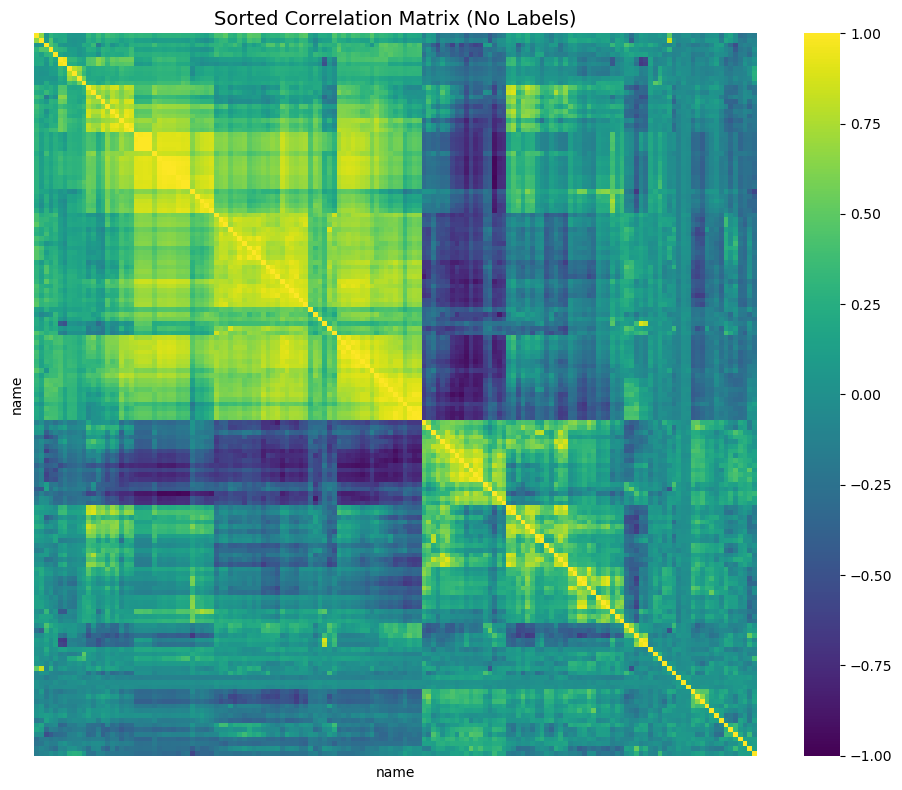

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import numpy as np

# Compute correlation matrix
corr = df_daily.corr()

# Get the linkage matrix for clustering
linkage = sch.linkage(corr, method='ward')
dendro = sch.dendrogram(linkage, no_plot=True)
idx = dendro['leaves']

# Reorder correlation matrix
sorted_corr = corr.iloc[idx, :].iloc[:, idx]

# Plot sorted correlation heatmap without variable names
plt.figure(figsize=(10, 8))
sns.heatmap(
    sorted_corr,
    cmap='viridis',
    square=True,
    cbar=True,
    vmin=-1, vmax=1,
    xticklabels=False,
    yticklabels=False
)

plt.title("Sorted Correlation Matrix (No Labels)", fontsize=14)
plt.tight_layout()
plt.show()


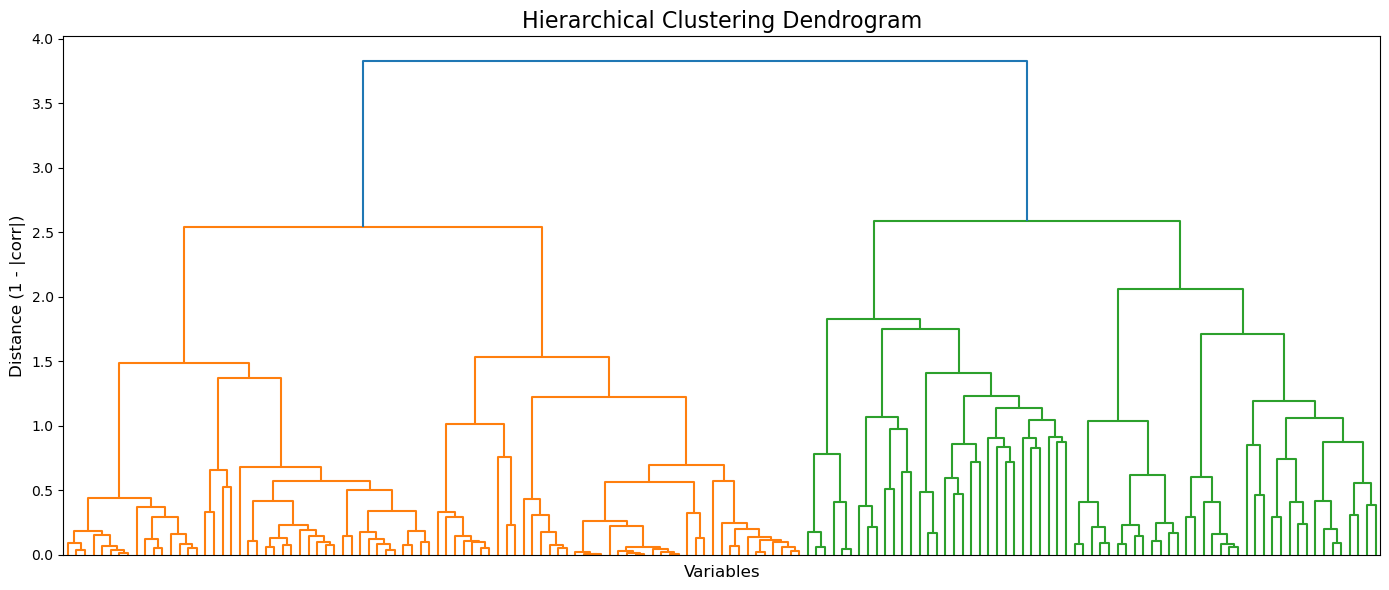

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

# Step 1: Compute correlation matrix
corr = df_daily.corr()

# Step 2: Convert to distance matrix (must be condensed for linkage)
# Using squareform ensures it's in the correct format for scipy
dist_matrix = 1 - corr.abs()
condensed_dist = squareform(dist_matrix.values, checks=False)

# Step 3: Compute linkage matrix using Ward's method
linkage = sch.linkage(condensed_dist, method='ward')

# Step 4: Plot dendrogram
plt.figure(figsize=(14, 6))
sch.dendrogram(
    linkage,
    no_labels=True,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.7 * max(linkage[:, 2])  # adjustable threshold
)
plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Distance (1 - |corr|)", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()


In [5]:
from scipy.cluster.hierarchy import fcluster

k = 8  # set number of clusters
labels = fcluster(linkage, k, criterion='maxclust')

# Create DataFrame with variable names and cluster assignment
clustered = pd.DataFrame({'Variable': corr.columns, 'Cluster': labels})
print(clustered.sort_values('Cluster'))


         Variable  Cluster
31        debt_me        1
85     nncoa_gr1a        1
128      sale_gr3        1
127      sale_gr1        1
126  sale_emp_gr1        1
..            ...      ...
107    qmj_safety        8
81    niq_at_chg1        8
114      ret_12_7        8
77       ni_inc8q        8
83    niq_be_chg1        8

[153 rows x 2 columns]


In [6]:
""" from scipy.cluster.hierarchy import linkage, leaves_list
# Hierarchical clustering to sort correlation matrix
link = linkage(corr, method='ward')
idx = leaves_list(link)
sorted_corr = corr.iloc[idx, idx]

mask = np.triu(np.ones_like(sorted_corr, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(sorted_corr, mask=mask, cmap='coolwarm', center=0, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": .8}, xticklabels=False, yticklabels=False)
plt.title("Clustered Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()
 """

' from scipy.cluster.hierarchy import linkage, leaves_list\n# Hierarchical clustering to sort correlation matrix\nlink = linkage(corr, method=\'ward\')\nidx = leaves_list(link)\nsorted_corr = corr.iloc[idx, idx]\n\nmask = np.triu(np.ones_like(sorted_corr, dtype=bool))\n\nplt.figure(figsize=(15, 12))\nsns.heatmap(sorted_corr, mask=mask, cmap=\'coolwarm\', center=0, fmt=".2f",\n            linewidths=0.5, cbar_kws={"shrink": .8}, xticklabels=False, yticklabels=False)\nplt.title("Clustered Correlation Matrix", fontsize=16)\nplt.tight_layout()\nplt.show()\n '

# Visuals

In [7]:
def plot_dof(df, x, p):
    """
    degrees of freedom <-> kappa plot
    
    Parameters:
    - df: Degrees of freedom data to be plotted on the y-axis.
    - x: Data to be plotted on the x-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot
    plt.plot(x, df, linewidth=p['line_width'])
    
    # Log-scale adjustments
    if p['L1_log_scale']:
        plt.yscale('log')
        plt.yticks([tick + 1e-12 for tick in plt.yticks()[0]])  # Adding a small constant
    
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-12 for tick in plt.xticks()[0]])  # Adding a small constant
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel('Effective degrees of freedom', fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Setting x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        plt.savefig('results_export/degrees_of_freedom.png', dpi=300, bbox_inches='tight')


def plot_L2coefpaths(x, phi, iL2opt, anomalies, ylbl, p):
    """
    L2 coefficients paths plot
    
    Parameters:
    - x: Data for the x-axis.
    - phi: Coefficient path data.
    - iL2opt: Optimal index for regularization.
    - anomalies: Names for legends.
    - ylbl: Label for the y-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Decide sorting location
    if p['L2_sort_loc'] == 'opt':
        iSortLoc = iL2opt
    elif p['L2_sort_loc'] == 'OLS':
        iSortLoc = 0
    else:
        raise ValueError('Unknown option')
    
    # Sorting mechanism
    if p['n'] > p['L2_max_legends']:
        I = np.argsort(-np.abs(phi[:, iSortLoc]))  # Descending sort by absolute value
    else:
        I = np.argsort(-phi[:, iSortLoc])  # Descending sort
    
    # Open a new figure
    plt.figure()
    
    # Plot
    for i in I:
        plt.plot(x, phi[i, :], linewidth=p['line_width'])
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(ylbl, fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Legend
    idx = I[:min(p['L2_max_legends'], len(I))]
    plt.legend([anomalies[i] for i in idx], loc=p['legend_loc'], fontsize=p['font_size'], bbox_to_anchor=(1.05, 1))
    
    # Dashed line at optimal regularization
    plt.plot([x[iL2opt], x[iL2opt]], [np.min(phi), np.max(phi)], '--k')
    
    # x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        if ylbl == 'SDF Coefficient, $b$':
            plt.savefig('results_export/coefficients_paths.png', dpi=300, bbox_inches='tight')
        elif ylbl == 'SDF Coefficient $t$-statistic':
            plt.savefig('results_export/tstats_paths.png', dpi=300, bbox_inches='tight')


def plot_L2cv(x, objL2, p):
    """
    Plot SSE/objective & BIC as a function of degrees of freedom.
    
    Parameters:
    - x: Data for the x-axis.
    - objL2: Data for plotting objectives and possible other values.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot In-sample (IS) and Out-of-Sample (OOS)
    plt.plot(x, objL2[:, 0], '--', linewidth=p['line_width'])  # IS
    plt.plot(x, objL2[:, 1], '-', linewidth=p['line_width'])  # OOS
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(f"IS/OOS {p['sObjective']}", fontsize=12, labelpad=10, fontweight='bold')
    
    # Legends and plot +1, -1 standard error
    co = plt.gca().lines[-1].get_color()  # Getting color of last line plotted (OOS line)
    plt.plot(x, objL2[:, 1] + objL2[:, 3], ':', color=co, linewidth=1)  # +1 SE
    plt.plot(x, objL2[:, 1] - objL2[:, 3], ':', color=co, linewidth=1)  # -1 SE
    
    plt.legend(['In-sample', f"OOS {p['method']}", f"OOS {p['method']} +/- 1 s.e."],
               loc='upper right')
    
    # Grid, axis limits
    plt.grid(True)
    plt.ylim([0, max(0.1, min(10, 2*max(objL2[:, 1])))])
    plt.xlim([min(x), 2])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        plt.savefig('results_export/cross_validation.png', dpi=300, bbox_inches='tight')



def table_L2coefs(phi, se, anomalies, p):
    """
    Function to display a table of largest coefficients and t-stats.

    Parameters:
    - phi: Coefficients.
    - se: Standard error.
    - anomalies: Anomaly descriptions.
    - p: Dictionary containing various parameters.
    """
    nrows = 10  # number of rows in the table to show
    
    # t-stats
    tstats = phi / se
    
    # by absolute tstats
    idx = np.argsort(np.abs(tstats))[::-1]
    
    # show only nrows items
    idx = idx[:nrows]
   
    # create a DataFrame
    data = {
        'Portfolio': [anomalies[i] for i in idx],
        'b': phi[idx],
        't_stat': np.abs(tstats[idx])
    }
    df = pd.DataFrame(data)
    
    # display table
    print(df)

    # export as a latex formatted table
    if p['results_export']:
        df.to_latex('results_export/coefficients_table.tex', index=False)

# Fixes index and def FUN

In [8]:
ff_dict_returns.index = df_wide.index
# Generate monthly dates as a Pandas Series
date_series = pd.Series(pd.date_range(start="1980-01-01", end="2023-12-01", freq='MS'))



# Accessing both .iloc and .strftime()
print(date_series.iloc[-1])  # Extract the last date (2023-12-01)
print(date_series.iloc[-1].strftime('%Y-%m-%d'))  # Format the last date as a string
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_daily_scaled = pd.DataFrame(scaler.fit_transform(df_daily), 
                               index=df_daily.index, 
                               columns=df_daily.columns)


spx_daily_ret_scaled = pd.DataFrame(scaler.fit_transform(spx_daily_ret), 
                               index=spx_daily_ret.index, 
                               columns=spx_daily_ret.columns)

def cs_r2_metric(F, b):
    """
    Compute cross-sectional R^2 in the hold-out set:
      R^2 = 1 - [ (mu_test - Sigma_test*b)^T (mu_test - Sigma_test*b ) / mu_test^T mu_test ]
    """
    mu_test = F.mean(axis=0)               # (H,)
    Sigma_test = np.cov(F, rowvar=False)   # (H, H)
    pred_mean = Sigma_test @ b            # shape (H,)

    numerator = np.sum((mu_test - pred_mean)**2)
    denominator = np.sum(mu_test**2)
    return 1.0 - numerator / denominator


2023-12-01 00:00:00
2023-12-01


# Define function

In [9]:

def SCS_L2est(dates, re, market, freq, anomalies, parameters):
    """
    Computes the L2 shrinkage estimator of the SDF parameters
    based on the method in Kozak, Nagel, and Santosh (2019).
    
    Parameters:
    - dates (pd.Series): time series of dates
    - re (pd.DataFrame): matrix of excess returns time series
    - market (pd.Series): matrix of market's excess returns time series
    - freq (int): number of observations per year
    - anomalies (list): list of anomaly names
    - kwargs: other optional keyword arguments
        * gridsize (int): default=20
        * cvmethod (str): default='CV'
        * kfold (int): default=4
        * objective (str): default='C-S R^2'
        * plot_dof (bool): default=False
        * plot_coefpaths (bool): default=False
        * plot_objective (bool): default=False
        * ... more parameters...
    
    Returns:
    - estimates (dict): structure of estimates
    
    Note: Always cite the paper when using this function.
    """

    # Assign default values
    parameters = {
        'gridsize': 100,
        'method': 'CV',
        'objective': 'CSR2',
        'ignore_scale': False,
        'kfold': 3,
        'oos_test_date': dates.iloc[-1700],
        'freq': freq,
        'rotate_PC': False,
        'demarket_conditionally': False,
        'demarket_unconditionally': True,
        'devol_conditionally': False,
        'devol_unconditionally': True,
        'plot_dof': True,
        'plot_coefpaths': True,
        'plot_objective': True,
        'line_width': 1.5,
        'font_size': 10,
        'L2_max_legends': 20,
        'L2_sort_loc': 'opt',
        'L1_log_scale': True,
        'L2_log_scale': True,
        'legend_loc': 'best',
        'results_export': True,
        'show_plot': False
    }

    # Parse config and assign default values
    # parameters = parse_config(parameters, default_config)

    # We usually maximize an objective (e.g., R^2), except for HJ-distance (GLS) and SSE
    if parameters["objective"] in ['GLS', 'SSE']:
        optfunc = min
    else:
        optfunc = max

    # User-friendly names for objectives to use in plots
    mapObj = {
        'CSR2': 'Cross-sectional $R^2$',
        'GLSR2': 'Cross-sectional GLS $R^2$',
        'GLS': 'Residual $SR^2$',
        'SRexpl': 'Explained SR',
        'SSE': 'SDF RMSE',
        'SR': 'Sharpe Ratio',
        'MVU': 'Mean-variance utility'
    }
    parameters["sObjective"] = mapObj[parameters["objective"]]

    # Initialize; compute means, cov, SVD decomposition
    # Testing sample start date
    tT0 = parameters["oos_test_date"]
    re.index = dates.values
    market.index = dates.values

    mkt0 = market.copy()

    # De-market all excess returns 
    if parameters['demarket_conditionally']:  # conditionally
        demarket_ma_window = 10 * parameters['freq']  # use past 3 years to estimate betas

        # Placeholder for custom function `demarkcond`
        r0 = demarketcond(re.iloc[idx_train, :], market.iloc[idx_train], demarket_ma_window)
        idx_train = idx_train[demarket_ma_window:]  # drop NaNs

    elif parameters['demarket_unconditionally']:  # unconditionally

        # Placeholder for custom function `demarket`
        r_train, b_train = demarket(re.loc[:tT0, :], market.loc[:tT0])
        r_test = demarket(re.loc[tT0:, :], market.loc[tT0:], b_train)  # use betas estimated in the training sample
        # check if r_test is a dataframe
        if isinstance(r_test, pd.DataFrame):
            r0 = pd.concat([r_train, r_test], axis=0)
        else:
            r0 = r_train.copy()

    else:
        r0 = re.copy()

    # De-vol all excess returns conditionally if requested
    if parameters['devol_conditionally']:
        devol_ma_window = 22  # use past 22 days to estimate volatilities

        # Placeholder for custom function `devolcond`
        r0, mkt0 = devolcond(r0, market, devol_ma_window)
        idx_train = idx_train[devol_ma_window:]  # drop NaNs

    elif parameters['devol_unconditionally']:  # de-vol unconditionally

        # Normalize so that all returns have the standard deviation of the VW market
        r0 = r0.divide(r0.std(axis=0), axis=1).multiply(market.std())

    # Construct dates, mkt, and returns for train and test sets
    mkt = mkt0.loc[:tT0]
    mkt_test = mkt0.loc[tT0:]

    r_train = r0.loc[:tT0, :]
    r_test = r0.loc[tT0:, :]

    # Length of the training sample
    T, n = r_train.shape
    parameters['T'] = T
    parameters['n'] = n

    # Rotate into PC space if requested and change file suffix
    if parameters.get('rotate_PC', True):
        # Use training sample to form eigenvectors
        _, _, Q = np.linalg.svd(np.cov(r_train, rowvar=False)) 
        r_train = np.dot(r_train, Q)
        r_test = np.dot(r_test, Q)
        anomalies = ['PC' + str(i) for i in range(1, n + 1)]

    # Compute first and second moments
    X = regcov(r_train)
    y = np.mean(r_train, axis=0)#.reshape(-1, 1)  # making y a column vector
    #X_test = regcov(r_test)  # TODO: test does not have data in it!!
    #y_test = np.mean(r_test, axis=0)#.reshape(-1, 1)  # making y_test a column vector

    # Maximum in-sample SR
    w = np.dot(np.dot(y.T, np.linalg.pinv(X)), y)
    maxSR2 = freq * w

    # Precompute E-V decomposition
    U, D, Q = np.linalg.svd(X)
    X2 = np.dot(np.dot(Q, np.sqrt(np.diag(D))), Q.T)
    d = np.sum(np.diag(D), axis=1)

    # Pre-compute pseudo inverses
    tol = max(X.shape) * np.finfo(float).eps * np.linalg.norm(d, np.inf)
    r1 = np.sum(d > tol) + 1
    Q1 = Q[:, :r1]
    s = d[:r1]
    s2 = 1 / np.sqrt(s)
    s = 1 / s
    Q1 = Q1.T
    Xinv = np.dot(Q1 * s.reshape(1, -1), Q1.T)
    X2inv = np.dot(Q1 * s2.reshape(1, -1), Q1.T)

    # Options
    parameters['xlbl'] = 'Root Expected SR$^2$ (prior), $\\kappa$'
    parameters['Q'] = Q
    parameters['d'] = d
    parameters['Xinv'] = Xinv


    # Functions to map L2pen <-> kappa
    kappa2pen = lambda kappa, T, X, p: p['freq'] * np.trace(X) / T / (kappa ** 2)

    # Find left and right limits
    lr = np.arange(1, 22)  # equivalent of 1:21 in MATLAB
    lm = 1

    z = np.empty((n, len(lr)))
    z.fill(np.nan)

    for i in lr:
        params = parameters.copy()  # Make a copy of p to avoid modifying the original
        params['L2pen'] = kappa2pen(2 ** (i - lm), T, X, parameters)
        z[:, i - 1] = l2est(X, y, params)[0]

    # Coefficient stabilize condition
    mean_val = np.mean(np.abs((z[:, 1:] - z[:, :-1])) / (1 + np.abs(z[:, :-1])), axis=0) > 0.01
    x_rlim = np.nonzero(mean_val)[0]

    # Use the left and right points to define the support and create a finer grid on this support
    x = np.logspace(np.log10(2**x_rlim[-1]), np.log10(0.01), parameters['gridsize'])
    l = [kappa2pen(val, T, X, parameters) for val in x]
    lCV = [val / (1 - 1 / parameters['kfold']) for val in l]  
    nl = len(l)

    # Estimate the L2 model
    params = parameters.copy() # Make a copy of p to avoid modifying the original

    # Create placeholders for outputs
    phi = np.full((n, nl), np.nan)
    se = np.full_like(phi, np.nan)
    objL2 = np.full((nl, 4), np.nan)
    objL2_folds = np.full((nl, params['kfold']), np.nan)  # Assuming params['kfold'] is the number of folds
    MVE = [None] * nl

    for i in range(nl):
        print(i)
        # Estimate parameters at each grid point
        params['L2pen'] = l[i]
        # Note: You need to define the l2est function in Python or provide its MATLAB code for translation
        phi[:, i], _, se[:, i] = l2est(X, y, params, True)

        # Cross validate estimated parameters
        params['L2pen'] = lCV[i]
        # Note: You need to define the cross_validate function in Python or provide its MATLAB code for translation
        objL2[i, :], params, objL2_folds_ = cross_validate(l2est, dates.values, r_train, params)
        objL2_folds[i, :] = objL2_folds_[:, 1] # Python is 0-indexed

        # Store OOS MVE portfolios for each CV run
        MVE[i] = params['cv_MVE']

    cv_idx_test = params['cv_idx_test'] 

    # Effective degrees of freedom
    df = np.sum(d.reshape(153,1) / (d.reshape(153,1) + np.array(l).reshape(1,100)), axis=0)

    # Optimal L2 model
    
    objL2opt = optfunc(objL2[:, 1])
    if optfunc == max:
        iL2opt = objL2[:, 1].argmax()
    if optfunc == min:
        iL2opt = objL2[:, 1].argmin()
    bL2 = phi[:, iL2opt]
    parameters['bL2'] = bL2
    parameters['R2oos'] = objL2opt
    L2optKappa = x[iL2opt]

    # MVE portfolios for each fold at the optimal level of shrinkage [flatten into single time-series]
    MVEopt = MVE[iL2opt]

    # Return coefficients paths, degrees of freedom, and objective's value
    parameters['coeffsPaths'] = phi
    parameters['objL2_IS'] = objL2[:, 0]
    parameters['objL2_OOS'] = objL2[:, 1]
    z = np.concatenate([MVEopt[key] for key in MVEopt], axis=0)
    parameters['optimal_model_L2'] = {
        'coefficients': bL2,
        'objective': objL2opt,
        'kappa': L2optKappa,
        'SR': np.mean(z) / np.std(z) * np.sqrt(parameters['freq'])
    }
    estimates = parameters

    # df <-> kappa plot
    if parameters['plot_dof']:  # plot degrees of freedom
        plot_dof(df, x, parameters)

    # SDF 2nd moment constraint (L2) coefficients 
    if parameters['plot_coefpaths']:
        # plot coefficients
        plot_L2coefpaths(x, phi, iL2opt, anomalies, 'SDF Coefficient, $b$', parameters)
        # plot t-stats
        plot_L2coefpaths(x, phi/se, iL2opt, anomalies, 'SDF Coefficient $t$-statistic', parameters)

    # L2 Cross-Validation/BIC plot
    if parameters['plot_objective']:
        plot_L2cv(x, objL2, parameters)

    # output table with coefficient & tstats estimates
    table_L2coefs(phi[:, iL2opt], se[:, iL2opt], anomalies, parameters)

    return estimates


In [10]:
df_daily_squeezed.shape

(8564, 153)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
     Portfolio         b    t_stat
0    nfna_gr1a  0.192420  0.976325
1  seas_6_10an  0.181906  0.924105
2     fnl_gr1a  0.181712  0.922005
3  resff3_12_1  0.171165  0.867709
4       noa_at  0.164836  0.835466
5       fcf_me  0.161198  0.813184
6       cop_at  0.159818  0.808450
7    capex_abn  0.146133  0.741093
8    cowc_gr1a  0.143164  0.726674
9    ncoa_gr1a  0.143521  0.724274


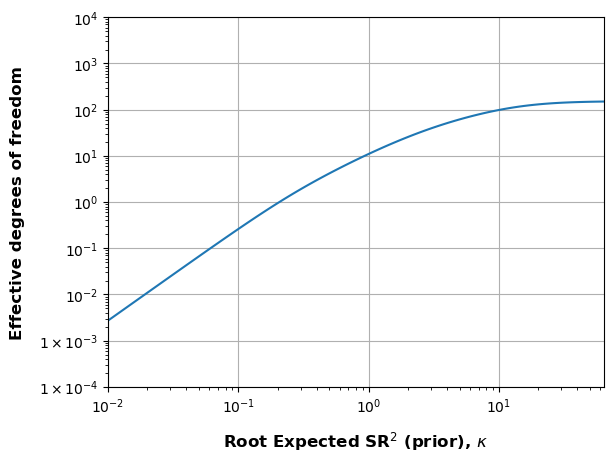

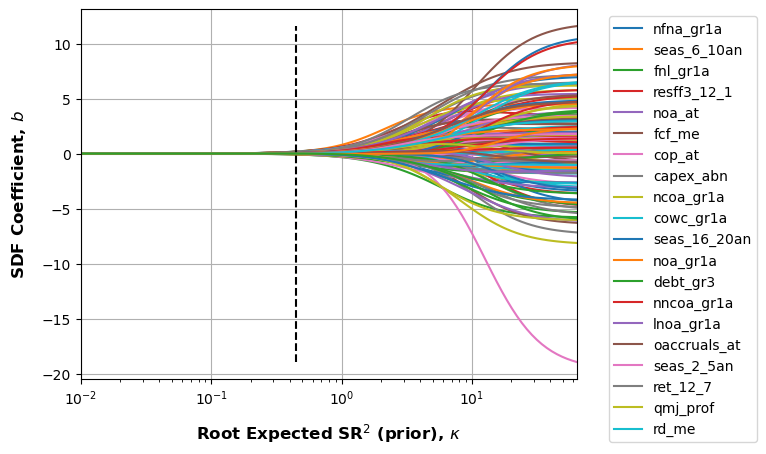

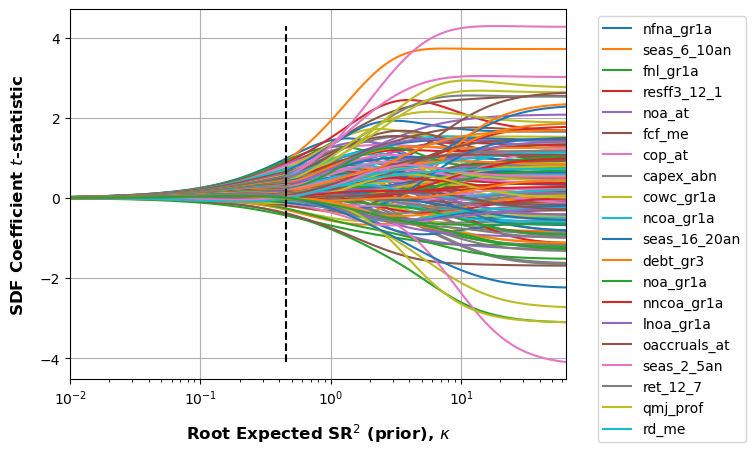

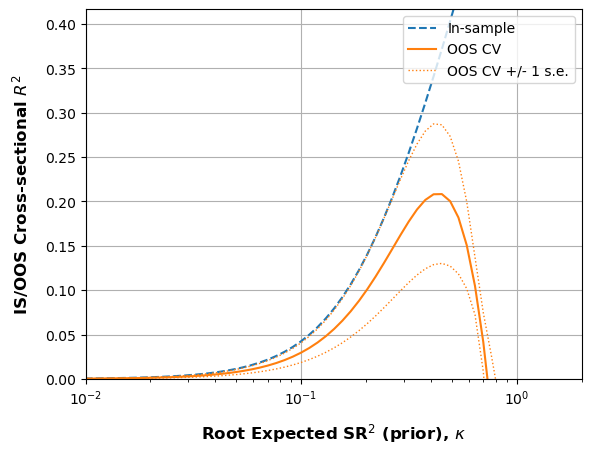

In [11]:
test = SCS_L2est(daily_date_series,df_daily_squeezed,spx_daily_ret_squeezed,252, daily_unique_values, {})

In [12]:
test

{'gridsize': 100,
 'method': 'CV',
 'objective': 'CSR2',
 'ignore_scale': False,
 'kfold': 3,
 'oos_test_date': Timestamp('2017-03-30 00:00:00'),
 'freq': 252,
 'rotate_PC': False,
 'demarket_conditionally': False,
 'demarket_unconditionally': True,
 'devol_conditionally': False,
 'devol_unconditionally': True,
 'plot_dof': True,
 'plot_coefpaths': True,
 'plot_objective': True,
 'line_width': 1.5,
 'font_size': 10,
 'L2_max_legends': 20,
 'L2_sort_loc': 'opt',
 'L1_log_scale': True,
 'L2_log_scale': True,
 'legend_loc': 'best',
 'results_export': True,
 'show_plot': False,
 'sObjective': 'Cross-sectional $R^2$',
 'T': 6865,
 'n': 153,
 'xlbl': 'Root Expected SR$^2$ (prior), $\\kappa$',
 'Q': array([[-1.24226114e-01,  1.27546782e-01, -8.56255642e-02, ...,
          1.15817972e-01,  1.13261435e-01,  1.16471470e-01],
        [-4.32245904e-02, -7.17125603e-04,  6.21530233e-02, ...,
          3.42941244e-02,  3.11942097e-02,  3.37432713e-02],
        [-3.44217980e-02, -3.55531004e-02,  2.3

# Dual-Penalty

In [13]:
train_size = int(len(df_daily) * 0.8)

x_train, x_test = df_daily[:train_size], df_daily[train_size:]
y_train, y_test = spx_daily_ret[:train_size], spx_daily_ret[train_size:]
freq = 252


#Training data
demarket_train = demarket(x_train,y_train)
demarket_train = demarket_train[0]
# Annualized here
demarket_train = demarket_train*freq
sigma_train = regcov(demarket_train)
mu_train = np.mean(demarket_train, axis=0)
sigma_train_inv = np.linalg.pinv(sigma_train)


#Training data split 

# Get total number of rows
num_rows = len(demarket_train)

# Calculate split sizes
split_size = num_rows // 2  # Integer division to get equal parts

# Split using iloc (Pandas indexing)
train_data_1 = demarket_train.iloc[:split_size]  
train_data_2 = demarket_train.iloc[split_size:]  

mu_1 = np.mean(train_data_1, axis=0)
mu_2 = np.mean(train_data_2, axis=0)


sigma_1 = regcov(train_data_1)
sigma_2 = regcov(train_data_2)



#Test data
demarket_test = demarket(x_test,y_test)
demarket_test = demarket_test[0]
demarket_test = demarket_test*freq
T,n = x_train.shape

sigma_test = regcov(demarket_test)
mu_test = np.mean(demarket_test)


tau = np.trace(sigma_test)
T = 153

# PC

  Principal Component  Explained Variance Ratio  Cumulative Variance
0                 PC1                  0.486091             0.486091
1                 PC2                  0.167424             0.653516
2                 PC3                  0.069668             0.723184
3                 PC4                  0.037155             0.760339
4                 PC5                  0.030592             0.790931
5                 PC6                  0.021121             0.812052
6                 PC7                  0.018228             0.830281
7                 PC8                  0.015208             0.845489
8                 PC9                  0.013458             0.858947
9                PC10                  0.011487             0.870434


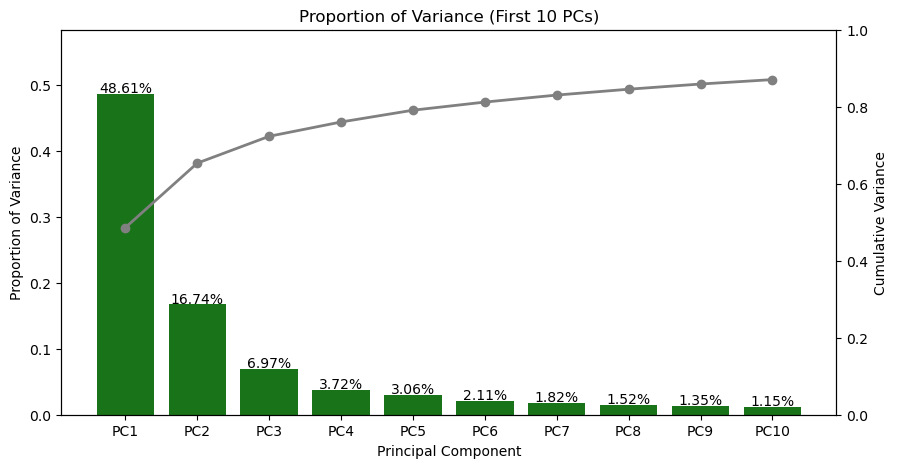

In [14]:
from sklearn.decomposition import PCA

test_PC = demarket(df_daily, spx_daily_ret)
test_PC = test_PC[0]
pca = PCA(n_components=153)
pca.fit(test_PC)

# Extract explained variance ratio and cumulative variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create DataFrame for display
pca_df = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(153)],
    "Explained Variance Ratio": explained_variance_ratio,
    "Cumulative Variance": cumulative_variance
})

# Display first 10 PCs
print(pca_df.head(10))

# Plot explained variance
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot for explained variance
bars = ax1.bar(range(1, 11), explained_variance_ratio[:10], color='darkgreen', alpha=0.9)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Proportion of Variance")
ax1.set_ylim(0, max(explained_variance_ratio[:10]) * 1.2)
ax1.set_xticks(range(1, 11))
ax1.set_xticklabels([f"PC{i}" for i in range(1, 11)])

# Annotate bars with percentages
for bar, percentage in zip(bars, explained_variance_ratio[:10]):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.002, f"{percentage:.2%}", ha='center', fontsize=10)

# Secondary axis for cumulative variance
ax2 = ax1.twinx()
ax2.plot(range(1, 11), cumulative_variance[:10], color='gray', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel("Cumulative Variance")
ax2.set_ylim(0, 1)

plt.title("Proportion of Variance (First 10 PCs)")
plt.grid(False)
plt.show()

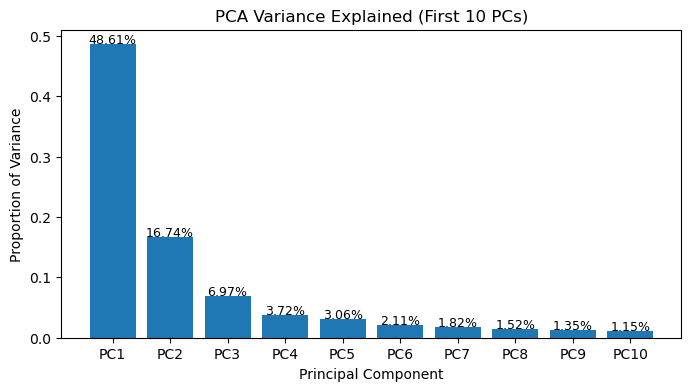

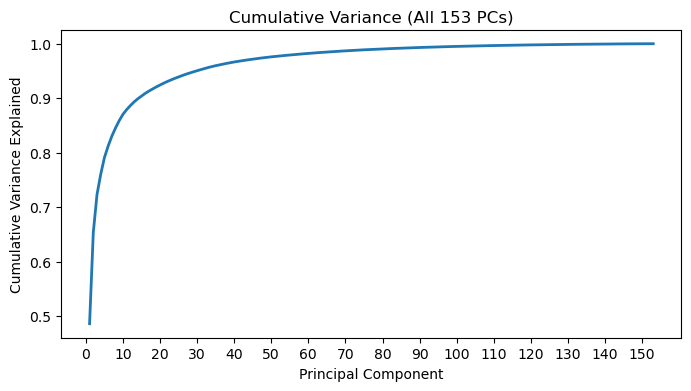

In [15]:
# Plot 1: Bar chart only for FIRST 10 PCs
plt.figure(figsize=(8, 4))
bars = plt.bar(range(1, 11), explained_variance_ratio[:10])
for bar, pct in zip(bars, explained_variance_ratio[:10]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f"{pct:.2%}", ha='center', fontsize=9)

plt.title("PCA Variance Explained (First 10 PCs)")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance")
plt.xticks(range(1, 11), [f"PC{i}" for i in range(1, 11)])
plt.show()

# Plot 2: Full scree (ALL 153 PCs), smooth cumulative variance line
plt.figure(figsize=(8, 4))
plt.plot(range(1, 154), cumulative_variance, linestyle='-', linewidth=2)
plt.title("Cumulative Variance (All 153 PCs)")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.xticks(range(0, 154, 10))
plt.show()

In [16]:
# Suppose 'pca' is your fitted PCA object. Build the DataFrame for the first 10 PCs:
pc_std = np.sqrt(pca.explained_variance_)
pca_table = pd.DataFrame({
    "PC": [f"PC{i}" for i in range(1, 11)],
    "Standard Deviation": pc_std[:10],
    "Proportion of Variance": pca.explained_variance_ratio_[:10],
    "Cumulative Proportion": np.cumsum(pca.explained_variance_ratio_[:10])
}).round(4)

# A small helper function to mimic a 'stargazer-like' LaTeX table for a DataFrame:
def stargazer_like_latex(df, caption="PCA (First 10 PCs)", label="tab:pca"):
    header_cols = " & ".join(df.columns) + " \\\\"
    col_alignment = "l" + "r"*(len(df.columns)-1)  # left col for names, right align others
    
    latex_str = [
        r"\begin{table}[htbp]\centering",
        f"\\caption{{{caption}}}\\label{{{label}}}",
        f"\\begin{{tabular}}{{{col_alignment}}}",
        r"\toprule",
        header_cols,
        r"\midrule"
    ]
    
    for row in df.itertuples(index=False):
        row_str = " & ".join(str(item) for item in row) + r" \\"
        latex_str.append(row_str)
    
    latex_str.extend([r"\bottomrule", r"\end{tabular}", r"\end{table}"])
    return "\n".join(latex_str)

# Generate and print the LaTeX string:
latex_code = stargazer_like_latex(pca_table)
print(latex_code)

\begin{table}[htbp]\centering
\caption{PCA (First 10 PCs)}\label{tab:pca}
\begin{tabular}{lrrr}
\toprule
PC & Standard Deviation & Proportion of Variance & Cumulative Proportion \\
\midrule
PC1 & 0.052 & 0.4861 & 0.4861 \\
PC2 & 0.0305 & 0.1674 & 0.6535 \\
PC3 & 0.0197 & 0.0697 & 0.7232 \\
PC4 & 0.0144 & 0.0372 & 0.7603 \\
PC5 & 0.013 & 0.0306 & 0.7909 \\
PC6 & 0.0108 & 0.0211 & 0.8121 \\
PC7 & 0.0101 & 0.0182 & 0.8303 \\
PC8 & 0.0092 & 0.0152 & 0.8455 \\
PC9 & 0.0087 & 0.0135 & 0.8589 \\
PC10 & 0.008 & 0.0115 & 0.8704 \\
\bottomrule
\end{tabular}
\end{table}


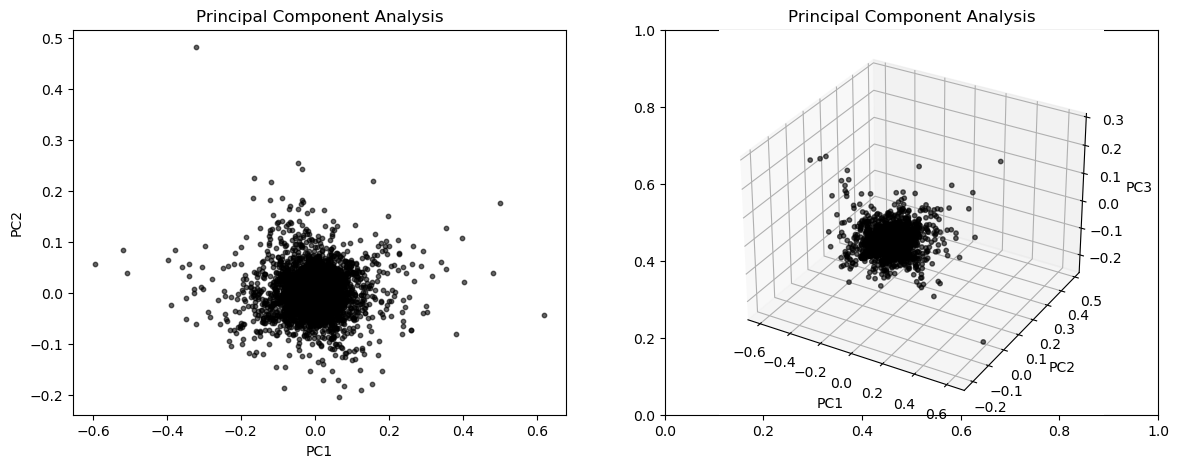

In [17]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming test_PC is a NumPy array with shape (8564, 153)
# Apply PCA to reduce to 3 components
pca_3d = PCA(n_components=3)
test_PC_transformed = pca_3d.fit_transform(test_PC)

# Extract first three principal components
pc1, pc2, pc3 = test_PC_transformed[:, 0], test_PC_transformed[:, 1], test_PC_transformed[:, 2]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2D scatter plot (PC1 vs PC2)
axes[0].scatter(pc1, pc2, alpha=0.6, color='black', s=10)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title("Principal Component Analysis")

# 3D scatter plot (PC1, PC2, PC3)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(pc1, pc2, pc3, alpha=0.6, color='black', s=10)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Principal Component Analysis")

plt.show()

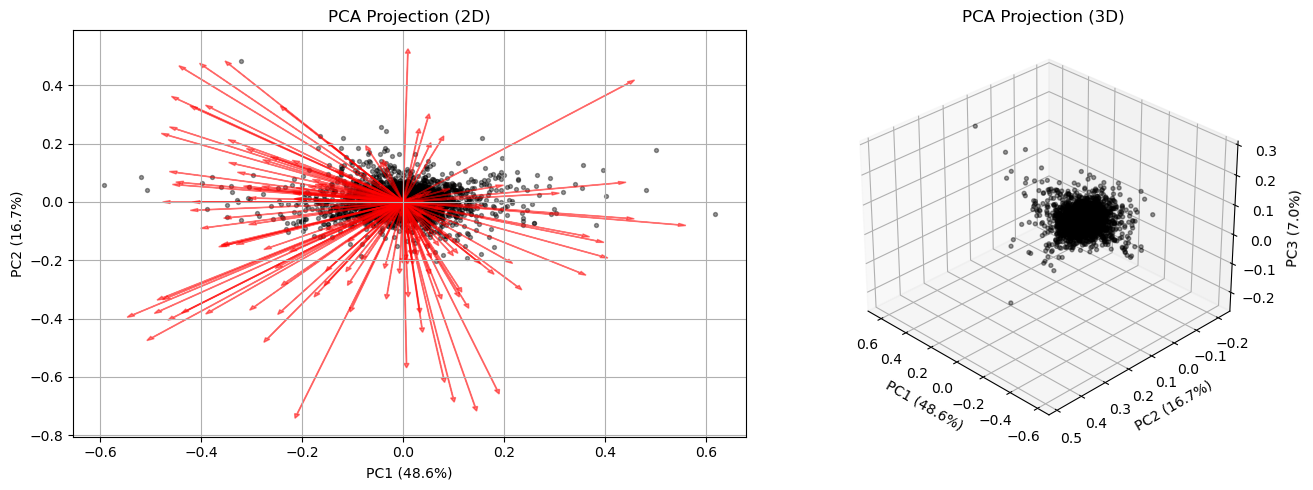

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa

# Fit PCA
pca_3d = PCA(n_components=3)
test_PC_transformed = pca_3d.fit_transform(test_PC)
components = pca_3d.components_  # shape: (3, n_features)
explained_var = pca_3d.explained_variance_ratio_ * 100

# Extract 2D coordinates
pc1, pc2, pc3 = test_PC_transformed[:, 0], test_PC_transformed[:, 1], test_PC_transformed[:, 2]

# Create plot
fig = plt.figure(figsize=(14, 5))

# --- 2D plot with loadings
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(pc1, pc2, alpha=0.4, s=8, c='black')
ax1.set_xlabel(f"PC1 ({explained_var[0]:.1f}%)")
ax1.set_ylabel(f"PC2 ({explained_var[1]:.1f}%)")
ax1.set_title("PCA Projection (2D)")
ax1.grid(True)

# Add loading vectors (first 2 PCs)
loadings = components[:2, :]  # shape (2, n_features)
scaling = 3  # adjust for visibility
for i in range(loadings.shape[1]):
    ax1.arrow(0, 0,
              scaling * loadings[0, i],
              scaling * loadings[1, i],
              color='red', alpha=0.5, head_width=0.01)

# Optional: show variable indices or names
    # ax1.text(scaling * loadings[0, i], scaling * loadings[1, i], f"V{i+1}", color='red', fontsize=6)

# --- 3D PCA plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(pc1, pc2, pc3, alpha=0.4, s=8, c='black')
ax2.set_xlabel(f"PC1 ({explained_var[0]:.1f}%)")
ax2.set_ylabel(f"PC2 ({explained_var[1]:.1f}%)")
ax2.set_zlabel(f"PC3 ({explained_var[2]:.1f}%)")
ax2.set_title("PCA Projection (3D)")
ax2.view_init(elev=30, azim=135)
ax2.grid(True)

plt.tight_layout()
plt.show()


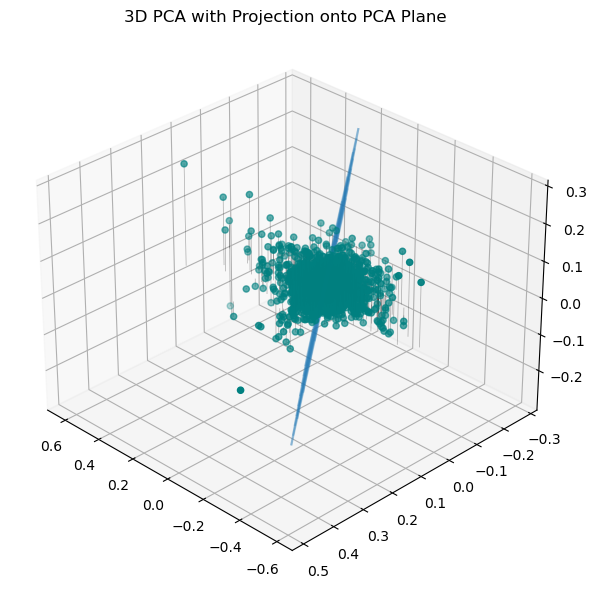

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Fit PCA to 3 components
pca3d = PCA(n_components=3)
X_3d = pca3d.fit_transform(test_PC)

# Step 2: Fit PCA again to 2 components for defining the PCA plane
pca2d = PCA(n_components=2)
X_2d = pca2d.fit_transform(test_PC)
X_2d_backproj = pca2d.inverse_transform(X_2d)
X_2d_backproj_3d = pca3d.transform(X_2d_backproj)

# Step 3: Plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter the original 3D PCA-transformed data
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c='teal', s=20)

# Draw vertical lines to the PCA plane
for i in range(len(X_3d)):
    ax.plot([X_3d[i, 0], X_2d_backproj_3d[i, 0]],
            [X_3d[i, 1], X_2d_backproj_3d[i, 1]],
            [X_3d[i, 2], X_2d_backproj_3d[i, 2]],
            color='black', alpha=0.3, linewidth=0.5)

# Plot the PCA plane using the mean and top 2 components
grid_range = np.linspace(-2, 2, 10)
grid_x, grid_y = np.meshgrid(grid_range, grid_range)
origin = pca3d.mean_

# The PCA plane spanned by first 2 PCs
plane = (
    origin +
    grid_x[..., np.newaxis] * pca3d.components_[0] +
    grid_y[..., np.newaxis] * pca3d.components_[1]
)

ax.plot_wireframe(plane[:, :, 0], plane[:, :, 1], plane[:, :, 2], alpha=0.3)

ax.set_title("3D PCA with Projection onto PCA Plane")
ax.view_init(elev=30, azim=135)
plt.tight_layout()
plt.show()


l1 ratio = 0 -> L2 (ridge)


l1 ratio = 1 -> L2 (lasso)
 

# Function for PC rotation

In [41]:
from datetime import datetime
import numpy as np
from utils_new import regcov



def plot_dof_PC(df, x, p):
    """
    degrees of freedom <-> kappa plot
    
    Parameters:
    - df: Degrees of freedom data to be plotted on the y-axis.
    - x: Data to be plotted on the x-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot
    plt.plot(x, df, linewidth=p['line_width'])
    
    # Log-scale adjustments
    if p['L1_log_scale']:
        plt.yscale('log')
        plt.yticks([tick + 1e-12 for tick in plt.yticks()[0]])  # Adding a small constant
    
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-12 for tick in plt.xticks()[0]])  # Adding a small constant
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel('Effective degrees of freedom', fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Setting x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export_PC']:
        plt.savefig('results_export/degrees_of_freedom_PC.png', dpi=300, bbox_inches='tight')




def plot_L2coefpaths_PC(x, phi, iL2opt, anomalies, ylbl, p):
    """
    L2 coefficients paths plot
    
    Parameters:
    - x: Data for the x-axis.
    - phi: Coefficient path data.
    - iL2opt: Optimal index for regularization.
    - anomalies: Names for legends.
    - ylbl: Label for the y-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Decide sorting location
    if p['L2_sort_loc'] == 'opt':
        iSortLoc = iL2opt
    elif p['L2_sort_loc'] == 'OLS':
        iSortLoc = 0
    else:
        raise ValueError('Unknown option')
    
    # Sorting mechanism
    if p['n'] > p['L2_max_legends']:
        I = np.argsort(-np.abs(phi[:, iSortLoc]))  # Descending sort by absolute value
    else:
        I = np.argsort(-phi[:, iSortLoc])  # Descending sort
    
    # Open a new figure
    plt.figure()
    
    # Plot
    for i in I:
        plt.plot(x, phi[i, :], linewidth=p['line_width'])
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(ylbl, fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Legend
    idx = I[:min(p['L2_max_legends'], len(I))]
    plt.legend([anomalies[i] for i in idx], loc=p['legend_loc'], fontsize=p['font_size'], bbox_to_anchor=(1.05, 1))
    
    # Dashed line at optimal regularization
    plt.plot([x[iL2opt], x[iL2opt]], [np.min(phi), np.max(phi)], '--k')
    
    # x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export_PC']:
        if ylbl == 'SDF Coefficient, $b$':
            plt.savefig('results_export/coefficients_paths_PC.png', dpi=300, bbox_inches='tight')
        elif ylbl == 'SDF Coefficient $t$-statistic':
            plt.savefig('results_export/tstats_paths_PC.png', dpi=300, bbox_inches='tight')



def table_L2coefs_PC(phi, se, anomalies, p):
    """
    Function to display a table of largest coefficients and t-stats.

    Parameters:
    - phi: Coefficients.
    - se: Standard error.
    - anomalies: Anomaly descriptions.
    - p: Dictionary containing various parameters.
    """
    nrows = 10  # number of rows in the table to show
    
    # t-stats
    tstats = phi / se
    
    # by absolute tstats
    idx = np.argsort(np.abs(tstats))[::-1]
    
    # show only nrows items
    idx = idx[:nrows]
   
    # create a DataFrame
    data = {
        'Portfolio': [anomalies[i] for i in idx],
        'b': phi[idx],
        't_stat': np.abs(tstats[idx])
    }
    df = pd.DataFrame(data)
    
    # display table
    print(df)

    # export as a latex formatted table
    if p['results_export_PC']:
        df.to_latex('results_export/coefficients_table_PC.tex', index=False)



def plot_L2cv_PC(x, objL2, p):
    """
    Plot SSE/objective & BIC as a function of degrees of freedom.
    
    Parameters:
    - x: Data for the x-axis.
    - objL2: Data for plotting objectives and possible other values.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot In-sample (IS) and Out-of-Sample (OOS)
    plt.plot(x, objL2[:, 0], '--', linewidth=p['line_width'])  # IS
    plt.plot(x, objL2[:, 1], '-', linewidth=p['line_width'])  # OOS
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(f"IS/OOS {p['sObjective']}", fontsize=12, labelpad=10, fontweight='bold')
    
    # Legends and plot +1, -1 standard error
    co = plt.gca().lines[-1].get_color()  # Getting color of last line plotted (OOS line)
    plt.plot(x, objL2[:, 1] + objL2[:, 3], ':', color=co, linewidth=1)  # +1 SE
    plt.plot(x, objL2[:, 1] - objL2[:, 3], ':', color=co, linewidth=1)  # -1 SE
    
    plt.legend(['In-sample', f"OOS {p['method']}", f"OOS {p['method']} +/- 1 s.e."],
               loc='upper right')
    
    # Grid, axis limits
    plt.grid(True)
    plt.ylim([0, max(0.1, min(10, 2*max(objL2[:, 1])))])
    plt.xlim([min(x), 2])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export_PC']:
        plt.savefig('results_export/cross_validation_PC.png', dpi=300, bbox_inches='tight')



def table_L2coefs_PC(phi, se, anomalies, p):
    """
    Function to display a table of largest coefficients and t-stats.

    Parameters:
    - phi: Coefficients.
    - se: Standard error.
    - anomalies: Anomaly descriptions.
    - p: Dictionary containing various parameters.
    """
    nrows = 10  # number of rows in the table to show
    
    # t-stats
    tstats = phi / se
    
    # by absolute tstats
    idx = np.argsort(np.abs(tstats))[::-1]
    
    # show only nrows items
    idx = idx[:nrows]
   
    # create a DataFrame
    data = {
        'Portfolio': [anomalies[i] for i in idx],
        'b': phi[idx],
        't_stat': np.abs(tstats[idx])
    }
    df = pd.DataFrame(data)
    
    # display table
    print(df)

    # export as a latex formatted table
    if p['results_export_PC']:
        df.to_latex('results_export/coefficients_table_PC.tex', index=False)

def cross_validate(FUN, dates, r, params):
    """
    Compute IS/OOS values of the objective function based on the FUN function.
    Implements multiple objectives and validation methods.

    Parameters:
    - FUN: Handle to a function which estimates model parameters.
    - dates: (T x 1) array of dates.
    - r: (T x N) matrix of returns.
    - params: Dictionary that contains extra arguments.

    Returns:
    - obj: (1 x 2) IS and OOS values of the estimated objective function.
    - params: Returns back the params dictionary.
    - obj_folds: ...
    """
    if not callable(FUN):
        raise ValueError('Provided FUN argument is not a callable function.')

    # Select requested method
    if 'method' not in params:
        cross_validate_handler = cross_validate_cv_handler
    else:
        map_cv_method = {
            'CV': cross_validate_cv_handler,
            'ssplit': cross_validate_ssplit_handler,
            # 'bootstrap': cross_validate_bootstrap_handler
        }
        cross_validate_handler = map_cv_method.get(params['method'])

    # Execute selected method
    params['dd'] = dates
    params['ret'] = r
    params['fun'] = FUN
    obj, params, obj_folds = cross_validate_handler(params)

    return obj, params, obj_folds

def cross_validate_ssplit_handler(params):
    """
    Sample split handler for cross-validation.

    Parameters:
    - params: Dictionary with parameters, including 'splitdate', 'dd', etc.

    Returns:
    - obj, params: Results from the bootstrp_handler.
    """
    # Get split date or default to '01JAN2000'
    sd = params.get('splitdate', '01JAN2000')

    # Convert string date to datetime object
    tT0 = datetime.strptime(sd, '%d%b%Y')
    idx_test = [i for i, d in enumerate(params['dd']) if d >= tT0]

    return bootstrp_handler(idx_test, params)


def cross_validate_cv_handler(params):
    """
    Perform k-fold cross-validation.
    
    Parameters:
    - params: dictionary containing the parameters
    
    Returns:
    - obj: (k x 2) array of IS and OOS values of the estimated objective function for each fold
    - params: updated params dictionary
    - obj_folds: (k x 2) array, equal to obj
    
    Note: Requires custom function `bootstrp_handler` and `cvpartition_contiguous`.
    """
    
    # Set k (number of folds) either to provided value or default to 2
    k = params.get('kfold', 2)
    
    cv = cvpartition_contiguous(np.size(params['ret'],0), k)
    
    # Initialize obj to hold IS/OOS stats for each partition
    obj = np.nan * np.zeros((k, 2))
    
    for i in range(k):
        
        idx_test = cv[i]
        if 'cv_idx_test' not in params:
            params['cv_idx_test'] = {}
        params['cv_idx_test'][i] = idx_test
        params['cv_iteration'] = i
        obj[i, :], params = bootstrp_handler(idx_test, params)
        
    # Store estimates for each fold
    obj_folds = obj
    
    # Compute average and standard error of IS/OOS stats across folds
    obj = np.hstack([np.mean(obj, axis=0), np.std(obj, axis=0) / np.sqrt(k)])
    
    # Uncomment and modify the following code if 'SRexpl' objective function is used
    # if params['objective'] == 'SRexpl':
    #     obj = np.sqrt(np.maximum(0, obj))
    
    return obj, params, obj_folds

def bootstrp_handler(idx_test, params):
    
    if 'objective' in params:
        map_bootstrp_obj = {
            #'SSE': bootstrp_obj_SSE,
            #'GLS': bootstrp_obj_HJdist,
            'CSR2': bootstrp_obj_CSR2,
            #'GLSR2': bootstrp_obj_GLSR2,
            #'SRexpl': bootstrp_obj_SRexpl,
            #'SR': bootstrp_obj_SR,
            #'MVU': bootstrp_obj_MVutil
        }
        
        def_bootstrp_obj = map_bootstrp_obj[params['objective']]
    else:
        def_bootstrp_obj = bootstrp_obj_CSR2

    ret = params['ret']
    FUN = params['fun']

    n = ret.shape[0]
    idx = np.setdiff1d(np.arange(n), idx_test)  # difference between two arrays, providing training indices
    n_test = len(idx_test)

    invX = np.nan
    invX_test = np.nan
    res = [np.nan, np.nan]

    if n_test > 0:
        r = ret.iloc[idx, :]
        r_test = ret.iloc[idx_test, :]

        if 'cv_cache' not in params or len(params['cv_cache']) <= params['cv_iteration']:
            if 'cv_cache' not in params:
                params['cv_cache'] = {}
            cvdata = {}
            cvdata['X'] = regcov(r)
            cvdata['y'] = np.mean(r, axis=0)
            cvdata['X_test'] = regcov(r_test)
            cvdata['y_test'] = np.mean(r_test, axis=0)
            
            if params['objective'] in {'GLS', 'GLSR2', 'SRexpl'}:
                cvdata['invX'] = np.linalg.pinv(cvdata['X'])
                cvdata['invX_test'] = np.linalg.pinv(cvdata['X_test'])

            params['cv_cache'][params['cv_iteration']] = cvdata

        cvdata = params['cv_cache'][params['cv_iteration']]
        X = cvdata['X']
        y = cvdata['y']
        X_test = cvdata['X_test']
        y_test = cvdata['y_test']
        
        if params['objective'] in {'GLS', 'GLSR2', 'SRexpl'}:
            invX = cvdata['invX']
            invX_test = cvdata['invX_test']

        phi, params = FUN(X, y, params)[0:2]

        if 'cache_run' not in params or not params['cache_run']:
            if 'cv_phi' not in params:
                params['cv_phi'] = {}
            params['cv_phi'][params['cv_iteration']] = phi
            if 'cv_MVE' not in params:
                params['cv_MVE'] = {}
            params['cv_MVE'][params['cv_iteration']] = np.dot(r_test, phi)
            
            fact = np.dot(X, phi)
            fact_test = np.dot(X_test, phi)

            if params['ignore_scale']:
                b = np.linalg.lstsq(fact, y, rcond=None)[0]
                b_test = np.linalg.lstsq(fact_test, y_test, rcond=None)[0]
            else:
                b = 1
                b_test = 1

            res = [
                def_bootstrp_obj(np.dot(fact, b), y, invX, phi, r, params),
                def_bootstrp_obj(np.dot(fact_test, b_test), y_test, invX_test, phi, r_test, params)
            ]

    return np.hstack(res), params

def cvpartition_contiguous(n, k):
    """
    Create contiguous partitions for cross-validation.
    
    Parameters:
    - n: int, total number of data points
    - k: int, number of folds/partitions
    
    Returns:
    - indices: list of lists, containing indices for each fold
    """
    s = n // k  # using floor division to ensure integer result
    indices = [None] * k  # Pre-allocating list with k None elements
    
    for i in range(k - 1):
        # Using range indexing to create contiguous partitions
        indices[i] = list(range(s * i, s * (i + 1)))
    
    # Last partition takes the remaining elements
    indices[k - 1] = list(range(s * (k - 1), n))
    
    return indices

def bootstrp_obj_CSR2(y_hat, y, invX, phi, r, params):
    """
    Compute the objective based on the Coefficient of Squared Regression (CSR2).

    Parameters:
    - y_hat: Predicted values
    - y: Actual values
    - invX, phi, r, params: Other parameters that are not used in the computation
      in this function but are kept for consistency with other objective functions.
    
    Returns:
    - obj: The computed CSR2 objective value.
    """
    # Compute the CSR2 objective
    obj = 1 - (np.dot((y_hat - y).T, (y_hat - y))) / (np.dot(y.T, y))
    return obj




def SCS_L2est(dates, re, market, freq, anomalies, parameters):
    """
    Computes the L2 shrinkage estimator of the SDF parameters
    based on the method in Kozak, Nagel, and Santosh (2019).
    
    Parameters:
    - dates (pd.Series): time series of dates
    - re (pd.DataFrame): matrix of excess returns time series
    - market (pd.Series): matrix of market's excess returns time series
    - freq (int): number of observations per year
    - anomalies (list): list of anomaly names
    - kwargs: other optional keyword arguments
        * gridsize (int): default=20
        * cvmethod (str): default='CV'
        * kfold (int): default=4
        * objective (str): default='C-S R^2'
        * plot_dof (bool): default=False
        * plot_coefpaths (bool): default=False
        * plot_objective (bool): default=False
        * ... more parameters...
    
    Returns:
    - estimates (dict): structure of estimates
    
    Note: Always cite the paper when using this function.
    """

    # Assign default values
    parameters = {
        'gridsize': 100,
        'method': 'CV',
        'objective': 'CSR2',
        'ignore_scale': False,
        'kfold': 3,
        'oos_test_date': dates.iloc[-1400],
        'freq': freq,
        'rotate_PC': True,
        'demarket_conditionally': False,
        'demarket_unconditionally': True,
        'devol_conditionally': False,
        'devol_unconditionally': True,
        'plot_dof_PC': True,
        'plot_coefpaths_PC': True,
        'plot_objective_PC': True,
        'line_width': 1.5,
        'font_size': 10,
        'L2_max_legends': 20,
        'L2_sort_loc': 'opt',
        'L1_log_scale': True,
        'L2_log_scale': True,
        'legend_loc': 'best',
        'results_export_PC': True,
        'show_plot': False
    }

    # Parse config and assign default values
    # parameters = parse_config(parameters, default_config)

    # We usually maximize an objective (e.g., R^2), except for HJ-distance (GLS) and SSE
    if parameters["objective"] in ['GLS', 'SSE']:
        optfunc = min
    else:
        optfunc = max

    # User-friendly names for objectives to use in plots
    mapObj = {
        'CSR2': 'Cross-sectional $R^2$',
        'GLSR2': 'Cross-sectional GLS $R^2$',
        'GLS': 'Residual $SR^2$',
        'SRexpl': 'Explained SR',
        'SSE': 'SDF RMSE',
        'SR': 'Sharpe Ratio',
        'MVU': 'Mean-variance utility'
    }
    parameters["sObjective"] = mapObj[parameters["objective"]]

    # Initialize; compute means, cov, SVD decomposition
    # Testing sample start date
    tT0 = parameters["oos_test_date"]
    re.index = dates.values
    market.index = dates.values

    mkt0 = market.copy()

    # De-market all excess returns 
    if parameters['demarket_conditionally']:  # conditionally
        demarket_ma_window = 10 * parameters['freq']  # use past 3 years to estimate betas

        # Placeholder for custom function `demarkcond`
        r0 = demarketcond(re.iloc[idx_train, :], market.iloc[idx_train], demarket_ma_window)
        idx_train = idx_train[demarket_ma_window:]  # drop NaNs

    elif parameters['demarket_unconditionally']:  # unconditionally

        # Placeholder for custom function `demarket`
        r_train, b_train = demarket(re.loc[:tT0, :], market.loc[:tT0])
        r_test = demarket(re.loc[tT0:, :], market.loc[tT0:], b_train)  # use betas estimated in the training sample
        # check if r_test is a dataframe
        if isinstance(r_test, pd.DataFrame):
            r0 = pd.concat([r_train, r_test], axis=0)
        else:
            r0 = r_train.copy()

    else:
        r0 = re.copy()

    # De-vol all excess returns conditionally if requested
    if parameters['devol_conditionally']:
        devol_ma_window = 22  # use past 22 days to estimate volatilities

        # Placeholder for custom function `devolcond`
        r0, mkt0 = devolcond(r0, market, devol_ma_window)
        idx_train = idx_train[devol_ma_window:]  # drop NaNs

    elif parameters['devol_unconditionally']:  # de-vol unconditionally

        # Normalize so that all returns have the standard deviation of the VW market
        r0 = r0.divide(r0.std(axis=0), axis=1).multiply(market.std())

    # Construct dates, mkt, and returns for train and test sets
    mkt = mkt0.loc[:tT0]
    mkt_test = mkt0.loc[tT0:]

    r_train = r0.loc[:tT0, :]
    r_test = r0.loc[tT0:, :]

    # Length of the training sample
    T, n = r_train.shape
    parameters['T'] = T
    parameters['n'] = n

    # Rotate into PC space if requested and change file suffix
    if parameters.get('rotate_PC', True):
        # Use training sample to form eigenvectors
        cov_matrix = r_train.cov().to_numpy()
        _, _, Q = np.linalg.svd(cov_matrix, full_matrices=True)
        r_train = pd.DataFrame(np.dot(r_train, Q), index=r_train.index, columns=r_train.columns)
        r_test = pd.DataFrame(np.dot(r_test, Q), index=r_test.index, columns=r_test.columns)
        anomalies = ['PC' + str(i) for i in range(1, n + 1)]

    # Compute first and second moments
    X = regcov(r_train)
    y = np.mean(r_train, axis=0)#.reshape(-1, 1)  # making y a column vector
    #X_test = regcov(r_test)  # TODO: test does not have data in it!!
    #y_test = np.mean(r_test, axis=0)#.reshape(-1, 1)  # making y_test a column vector

    # Maximum in-sample SR
    w = np.dot(np.dot(y.T, np.linalg.pinv(X)), y)
    maxSR2 = freq * w

    # Precompute E-V decomposition
    U, D, Q = np.linalg.svd(X)
    X2 = np.dot(np.dot(Q, np.sqrt(np.diag(D))), Q.T)
    d = np.sum(np.diag(D), axis=1)

    # Pre-compute pseudo inverses
    tol = max(X.shape) * np.finfo(float).eps * np.linalg.norm(d, np.inf)
    r1 = np.sum(d > tol) + 1
    Q1 = Q[:, :r1]
    s = d[:r1]
    s2 = 1 / np.sqrt(s)
    s = 1 / s
    Q1 = Q1.T
    Xinv = np.dot(Q1 * s.reshape(1, -1), Q1.T)
    X2inv = np.dot(Q1 * s2.reshape(1, -1), Q1.T)

    # Options
    parameters['xlbl'] = 'Root Expected SR$^2$ (prior), $\\kappa$'
    parameters['Q'] = Q
    parameters['d'] = d
    parameters['Xinv'] = Xinv


    # Functions to map L2pen <-> kappa
    kappa2pen = lambda kappa, T, X, p: p['freq'] * np.trace(X) / T / (kappa ** 2)

    # Find left and right limits
    lr = np.arange(1, 22)  # equivalent of 1:21 in MATLAB
    lm = 1

    z = np.empty((n, len(lr)))
    z.fill(np.nan)

    for i in lr:
        params = parameters.copy()  # Make a copy of p to avoid modifying the original
        params['L2pen'] = kappa2pen(2 ** (i - lm), T, X, parameters)
        z[:, i - 1] = l2est(X, y, params)[0]

    # Coefficient stabilize condition
    mean_val = np.mean(np.abs((z[:, 1:] - z[:, :-1])) / (1 + np.abs(z[:, :-1])), axis=0) > 0.01
    x_rlim = np.nonzero(mean_val)[0]

    # Use the left and right points to define the support and create a finer grid on this support
    x = np.logspace(np.log10(2**x_rlim[-1]), np.log10(0.01), parameters['gridsize'])
    l = [kappa2pen(val, T, X, parameters) for val in x]
    lCV = [val / (1 - 1 / parameters['kfold']) for val in l]  
    nl = len(l)

    # Estimate the L2 model
    params = parameters.copy() # Make a copy of p to avoid modifying the original

    # Create placeholders for outputs
    phi = np.full((n, nl), np.nan)
    se = np.full_like(phi, np.nan)
    objL2 = np.full((nl, 4), np.nan)
    objL2_folds = np.full((nl, params['kfold']), np.nan)  # Assuming params['kfold'] is the number of folds
    MVE = [None] * nl

    for i in range(nl):
        print(i)
        # Estimate parameters at each grid point
        params['L2pen'] = l[i]
        # Note: You need to define the l2est function in Python or provide its MATLAB code for translation
        phi[:, i], _, se[:, i] = l2est(X, y, params, True)

        # Cross validate estimated parameters
        params['L2pen'] = lCV[i]
        # Note: You need to define the cross_validate function in Python or provide its MATLAB code for translation
        objL2[i, :], params, objL2_folds_ = cross_validate(l2est, dates.values, r_train, params)
        objL2_folds[i, :] = objL2_folds_[:, 1] # Python is 0-indexed

        # Store OOS MVE portfolios for each CV run
        MVE[i] = params['cv_MVE']

    cv_idx_test = params['cv_idx_test'] 

    # Effective degrees of freedom
    df = np.sum(d.reshape(153,1) / (d.reshape(153,1) + np.array(l).reshape(1,100)), axis=0)

    # Optimal L2 model
    
    objL2opt = optfunc(objL2[:, 1])
    if optfunc == max:
        iL2opt = objL2[:, 1].argmax()
    if optfunc == min:
        iL2opt = objL2[:, 1].argmin()
    bL2 = phi[:, iL2opt]
    parameters['bL2'] = bL2
    parameters['R2oos'] = objL2opt
    L2optKappa = x[iL2opt]

    # MVE portfolios for each fold at the optimal level of shrinkage [flatten into single time-series]
    MVEopt = MVE[iL2opt]

    # Return coefficients paths, degrees of freedom, and objective's value
    parameters['coeffsPaths'] = phi
    parameters['objL2_IS'] = objL2[:, 0]
    parameters['objL2_OOS'] = objL2[:, 1]
    z = np.concatenate([MVEopt[key] for key in MVEopt], axis=0)
    parameters['optimal_model_L2'] = {
        'coefficients': bL2,
        'objective': objL2opt,
        'kappa': L2optKappa,
        'SR': np.mean(z) / np.std(z) * np.sqrt(parameters['freq'])
    }
    estimates = parameters

    # df <-> kappa plot
    if parameters['plot_dof_PC']:  # plot degrees of freedom
        plot_dof_PC(df, x, parameters)

    # SDF 2nd moment constraint (L2) coefficients 
    if parameters['plot_coefpaths_PC']:
        # plot coefficients
        plot_L2coefpaths_PC(x, phi, iL2opt, anomalies, 'SDF Coefficient, $b$', parameters)
        # plot t-stats
        plot_L2coefpaths_PC(x, phi/se, iL2opt, anomalies, 'SDF Coefficient $t$-statistic', parameters)

    # L2 Cross-Validation/BIC plot
    if parameters['plot_objective_PC']:
        plot_L2cv_PC(x, objL2, parameters)

    # output table with coefficient & tstats estimates
    table_L2coefs_PC(phi[:, iL2opt], se[:, iL2opt], anomalies, parameters)

    return estimates


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
  Portfolio         b    t_stat
0      PC31 -0.206564  1.043314
1      PC59 -0.194756  1.003859
2      PC73 -0.179786  0.906652
3      PC46  0.177385  0.905438
4      PC94  0.175474  0.888148
5     PC120  0.157025  0.796511
6      PC13 -0.155715  0.787814
7     PC137  0.155321  0.786048
8      PC67  0.150540  0.764205
9     PC146 -0.139545  0.701856


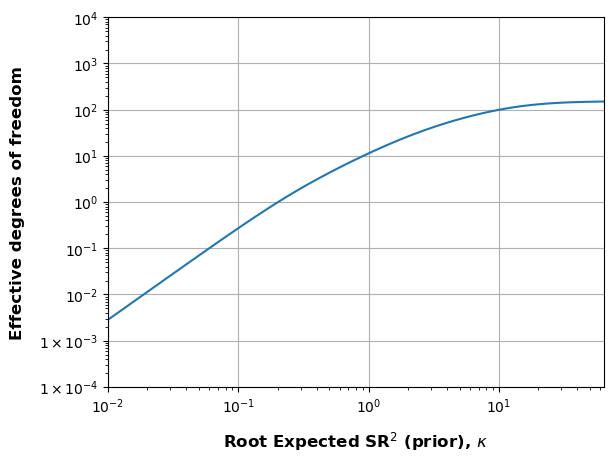

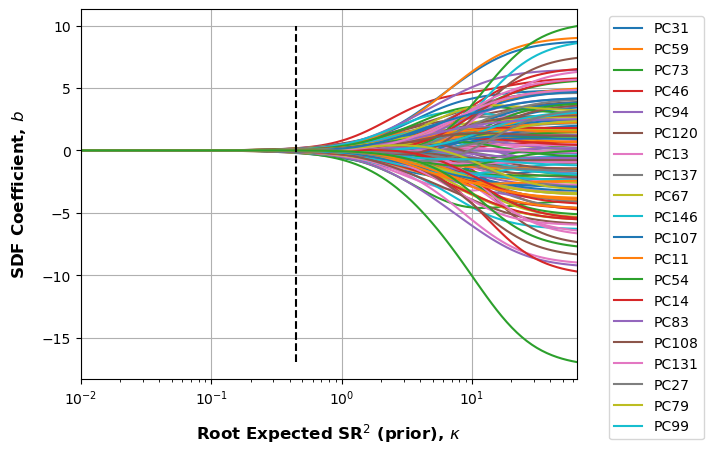

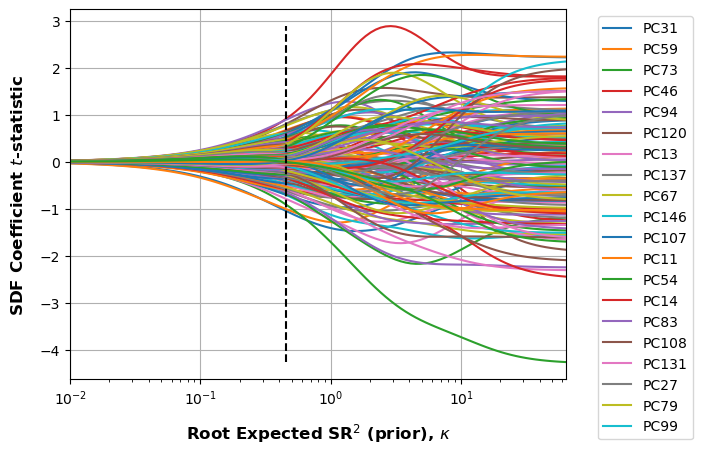

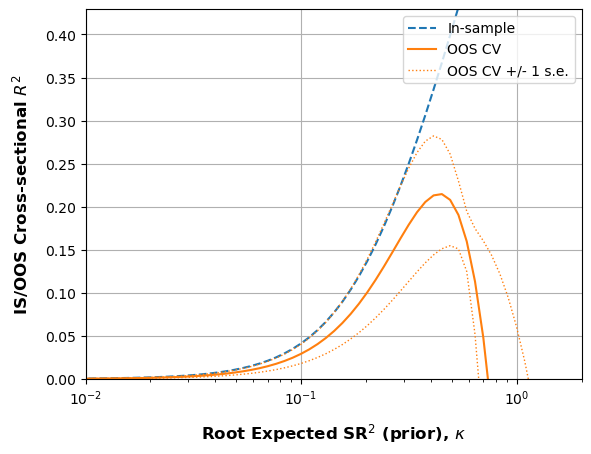

In [42]:
test_PC = SCS_L2est(daily_date_series, df_daily_squeezed, spx_daily_ret_squeezed, 252,daily_unique_values, {})

# Portfolio optimization 

1 year investment horizon

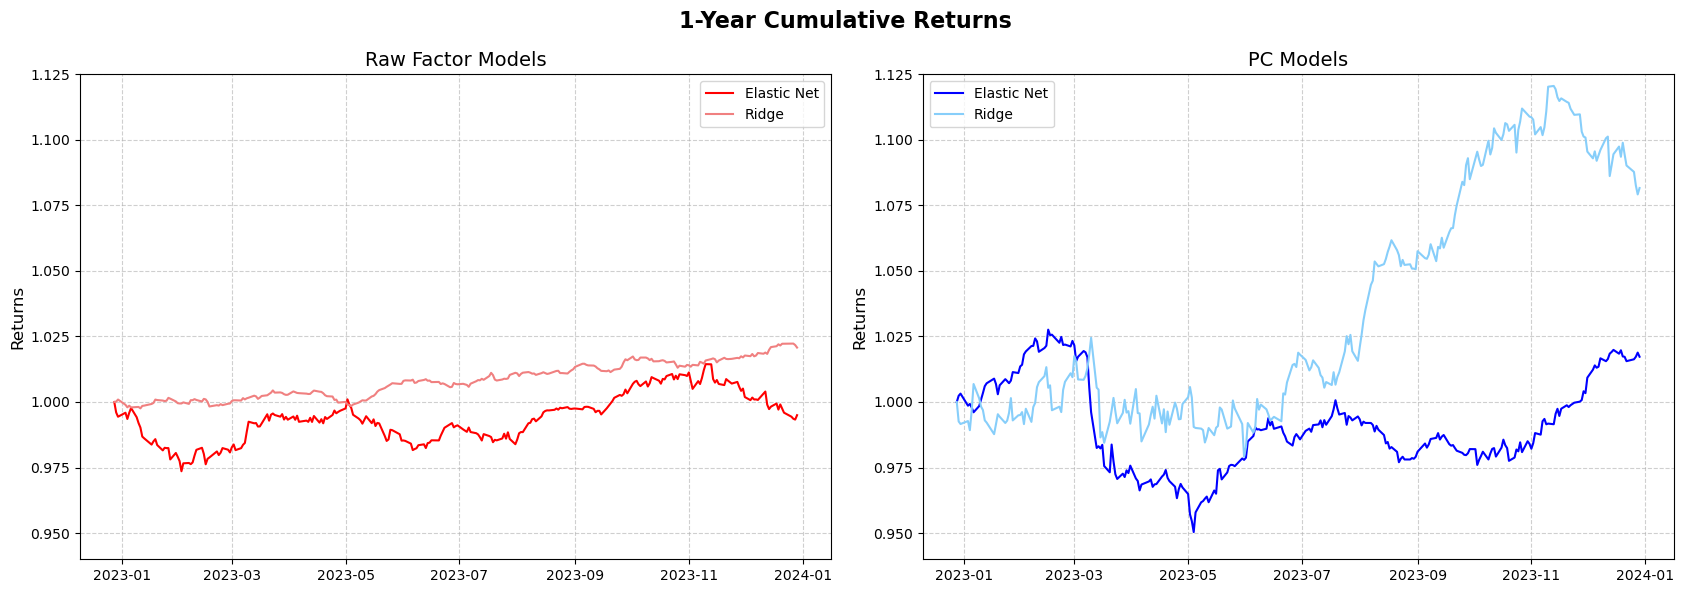

In [22]:
def compute_weights(coefficients):
    coefficients = np.array(coefficients)
    denominator = len(coefficients) + 1
    ranks = coefficients.argsort().argsort() + 1
    rc_i = ranks / denominator
    rc_bar = rc_i.mean()
    z = rc_i - rc_bar
    z_abs = np.abs(z).sum()
    weights = z / z_abs
    return weights




 
# Normalization of weights L2 
coefficients_1y = test['optimal_model_L2']['coefficients']
coefficients_1y = compute_weights(coefficients_1y)

# Normalization of weights L2_PC


coefficients_PC_1y = test_PC['optimal_model_L2']['coefficients']
#coefficients_PC_1y = compute_weights(coefficients_PC_1y)
oos_test_data = df_daily_squeezed.iloc[8312:]
oos_test_data = oos_test_data 
SPX_port = spx_daily_ret_squeezed[8312:]
SPX_port = SPX_port 
U, S, Vt = np.linalg.svd(oos_test_data, full_matrices=False)
oos_test_data_PC = Vt @ oos_test_data.T
L2_return_PC = coefficients_PC_1y @ oos_test_data_PC
L2_return_PC_SR = L2_return_PC
L2_return = coefficients_1y @ oos_test_data.T
L2_return_SR = L2_return
first_date = L2_return.index.min()
new_date = first_date - pd.Timedelta(days=1)


new_row_1y = pd.Series([0], index=[new_date])


L2_return = pd.concat([new_row_1y, L2_return])
L2_1y_portfolio_return = (1 + np.cumsum(L2_return))
#spx_test = (1 + np.cumsum(SPX_port))
L2_return_PC = pd.concat([new_row_1y, L2_return_PC])
L2_1y_portfolio_return_PC = (1 + np.cumsum(L2_return_PC))


# Load and preprocess L1L2_PC
L1L2_PC = pd.read_csv("C:/Users/ulrik/Desktop/best_PC_model.csv")
L1L2_PC = L1L2_PC.iloc[:, 1:]  # Remove first column
L1L2_PC = L1L2_PC.iloc[:, :-2]  # Remove last two columns

L1L2_PC = L1L2_PC.to_numpy().flatten()
#L1L2_PC = compute_weights(L1L2_PC)

# Normalization of weights L1L2_PC 

# Perform matrix multiplication
L1L2_returns_PC = (L1L2_PC @ oos_test_data.T)
L1L2_returns_PC_SR = L1L2_returns_PC
# Convert to Pandas Series with proper indexing
L1L2_returns_PC = pd.Series(L1L2_returns_PC, index=oos_test_data.index)
L1L2_returns_PC = pd.concat([new_row_1y, L1L2_returns_PC])

L1L2_1y_returns_PC = (1 + np.cumsum(L1L2_returns_PC))

L1L2_raw = pd.read_csv("C:/Users/ulrik/Desktop/best_model.csv")
L1L2_raw = L1L2_raw.iloc[:,1 :-2]
# Normalization of weights L1L2
L1L2_raw = L1L2_raw.to_numpy().flatten()
L1L2_raw = compute_weights(L1L2_raw)
L1L2_returns = (L1L2_raw @ oos_test_data.T)
#L1L2_returns = L1L2_returns.squeeze()





# Get the first date and create a new date one day before
first_date_1y = L1L2_returns.index.min()
new_date_1y = first_date_1y - pd.Timedelta(days=1)

# Create a new Series with the zero value
new_row = pd.Series([0], index=[new_date_1y])

# Concatenate the new row with the existing Series
L1L2_1y_returns_raw = pd.concat([new_row, L1L2_returns])

# Ensure the index remains sorted (optional)
L1L2_1y_returns_raw = L1L2_1y_returns_raw.sort_index()

L1L2_1y_returns_raw = (1 + np.cumsum(L1L2_1y_returns_raw))

import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(17, 6), sharex=True)

# Add a headline centered above both subplots
fig.suptitle("1-Year Cumulative Returns", fontsize=16, fontweight='bold')

# First subplot: _PC series (light blue)
axes[1].plot(L1L2_1y_returns_PC, label="Elastic Net", linestyle='-', linewidth=1.5, color="blue")
axes[1].plot(L2_1y_portfolio_return_PC, label="Ridge", linestyle='-', linewidth=1.5, color="lightskyblue")
axes[1].set_title("PC Models", fontsize=14)
axes[1].set_ylabel("Returns", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].set_ylim(0.94, 1.125)

# Second subplot: Non-PC series (light red)
axes[0].plot(L1L2_1y_returns_raw, label="Elastic Net", linestyle='-', linewidth=1.5, color="red")
axes[0].plot(L2_1y_portfolio_return, label="Ridge", linestyle='-', linewidth=1.5, color="lightcoral")
axes[0].set_title("Raw Factor Models", fontsize=14)

axes[0].set_ylabel("Returns", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].set_ylim(0.94, 1.125)

# Rotate x-axis labels for better readability
#plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



In [23]:
L1L2_1y_returns_PC_voladj = np.mean(L1L2_returns_PC_SR) / L1L2_returns_PC_SR.std()
L2_1y_portfolio_return_PC_voladj = np.mean(L2_return_PC_SR) / L2_return_PC_SR.std()
L1L2_1y_returns_raw_voladj = np.mean(L1L2_returns) / L1L2_returns.std() 
L2_1y_portfolio_return_voladj = np.mean(L2_return_SR) / L2_return_SR.std()

T = 252
n = 153

def sharpe_ratio_se(SR, T):
    SR_leftside = SR - 1.96 * np.sqrt((1 + (SR**2) / 2) / T)
    SR_rightside = SR + 1.96 * np.sqrt((1 + (SR**2) / 2) / T)
    return SR_leftside, SR_rightside

# Calculate Standard Errors
L1L2_1y_returns_PC_SE_left, L1L2_1y_returns_PC_SE_right = sharpe_ratio_se(L1L2_1y_returns_PC_voladj, T)
L2_1y_portfolio_return_PC_SE_left, L2_1y_portfolio_return_PC_SE_right = sharpe_ratio_se(L2_1y_portfolio_return_PC_voladj, T)
L1L2_1y_returns_raw_SE_left, L1L2_1y_portfolio_return_PC_SE_right = sharpe_ratio_se(L1L2_1y_returns_raw_voladj, T)
L2_1y_portfolio_return_SE_left, L2_1y_portfolio_return_SE_right = sharpe_ratio_se(L2_1y_portfolio_return_voladj, T)




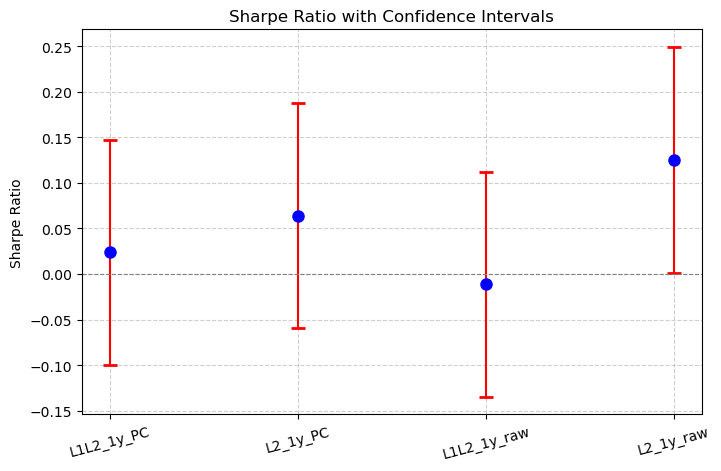

In [24]:
# Given T (number of observations)
T = 252

# Compute Sharpe Ratios
SR_values = {
    "L1L2_1y_PC": np.mean(L1L2_returns_PC_SR) / L1L2_returns_PC_SR.std(),
    "L2_1y_PC": np.mean(L2_return_PC_SR) / L2_return_PC_SR.std(),
    "L1L2_1y_raw": np.mean(L1L2_returns) / L1L2_returns.std(),
    "L2_1y_raw": np.mean(L2_return_SR) / L2_return_SR.std(),
}

# Function to compute confidence bounds for Sharpe Ratio
def sharpe_ratio_se(SR, T):
    margin_of_error = 1.96 * np.sqrt((1 + (SR**2) / 2) / T)
    return SR - margin_of_error, SR + margin_of_error

# Compute left and right confidence bounds
SR_CI = {key: sharpe_ratio_se(SR, T) for key, SR in SR_values.items()}

# Plot Sharpe Ratios with Confidence Intervals
fig, ax = plt.subplots(figsize=(8, 5))

labels = list(SR_values.keys())
SRs = list(SR_values.values())
lower_bounds = [SR_CI[key][0] for key in labels]
upper_bounds = [SR_CI[key][1] for key in labels]

# Plot SR values with error bars
ax.errorbar(labels, SRs, 
            yerr=[np.array(SRs) - np.array(lower_bounds), np.array(upper_bounds) - np.array(SRs)], 
            fmt='o', capsize=5, capthick=2, color='b', ecolor='r', markersize=8)

ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe Ratio with Confidence Intervals")
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
ax.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=15)
plt.show()

In [25]:
# Given T (number of observations)
T = 252

# Compute Sharpe Ratios
SR_values = {
    "L1L2_1y_PC": np.mean(L1L2_returns_PC_SR) / L1L2_returns_PC_SR.std(),
    "L2_1y_PC": np.mean(L2_return_PC_SR) / L2_return_PC_SR.std(),
    "L1L2_1y_raw": np.mean(L1L2_returns) / L1L2_returns.std(),
    "L2_1y_raw": np.mean(L2_return_SR) / L2_return_SR.std(),
}

# Function to compute confidence bounds for Sharpe Ratio
def sharpe_ratio_se(SR, T):
    margin_of_error = 1.96 * np.sqrt((1 + (SR**2) / 2) / T)
    return SR - margin_of_error, SR + margin_of_error

# Compute left and right confidence bounds
SR_CI = {key: sharpe_ratio_se(SR, T) for key, SR in SR_values.items()}

# Create DataFrame for table presentation
df_results = pd.DataFrame({
    "Portfolio": SR_values.keys(),
    "Sharpe Ratio": SR_values.values(),
    "Lower Bound (95% CI)": [SR_CI[key][0] for key in SR_values.keys()],
    "Upper Bound (95% CI)": [SR_CI[key][1] for key in SR_values.keys()]
})

# Apply styling for a cleaner output
styled_df = df_results.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}]
).set_caption("Sharpe Ratios with 95% Confidence Intervals")

# Display table in Jupyter Notebook
display(styled_df)
print(df_results.to_latex(index=True))


,Portfolio,Sharpe Ratio,Lower Bound (95% CI),Upper Bound (95% CI)
0,L1L2_1y_PC,0.023577,-0.099908,0.147063
1,L2_1y_PC,0.064045,-0.059550,0.187640
2,L1L2_1y_raw,-0.011439,-0.134911,0.112033
3,L2_1y_raw,0.125135,0.001184,0.249086


\begin{tabular}{llrrr}
\toprule
{} &    Portfolio &  Sharpe Ratio &  Lower Bound (95\% CI) &  Upper Bound (95\% CI) \\
\midrule
0 &   L1L2\_1y\_PC &      0.023577 &             -0.099908 &              0.147063 \\
1 &     L2\_1y\_PC &      0.064045 &             -0.059550 &              0.187640 \\
2 &  L1L2\_1y\_raw &     -0.011439 &             -0.134911 &              0.112033 \\
3 &    L2\_1y\_raw &      0.125135 &              0.001184 &              0.249086 \\
\bottomrule
\end{tabular}



Full investment horizon

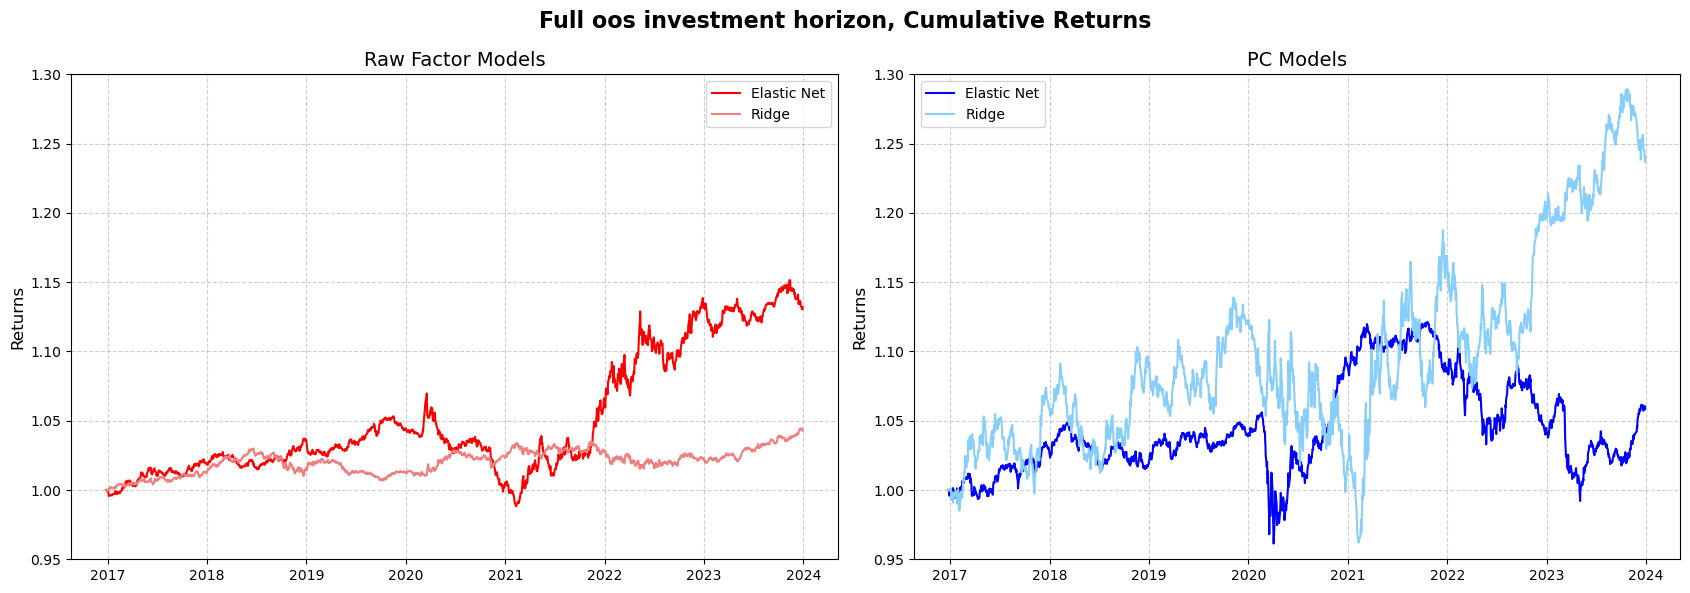

In [26]:

#coefficients_1y = test['optimal_model_L2']['coefficients']

#coefficients_PC_1y = test_PC['optimal_model_L2']['coefficients']
oos_test_data = df_daily_squeezed.iloc[6800:]
oos_test_data = oos_test_data 
SPX_port = spx_daily_ret_squeezed[6800:]
SPX_port = SPX_port 
U, S, Vt = np.linalg.svd(oos_test_data, full_matrices=False)
oos_test_data_PC = Vt @ oos_test_data.T
L2_return_PC = coefficients_PC_1y @ oos_test_data_PC
L2_return = coefficients_1y @ oos_test_data.T

first_date = L2_return.index.min()
new_date = first_date - pd.Timedelta(days=1)


new_row = pd.Series([0], index=[new_date])


L2_return = pd.concat([new_row, L2_return])
L2_1y_portfolio_return = (1 + np.cumsum(L2_return))
#spx_test = (1 + np.cumsum(SPX_port))
L2_return_PC = pd.concat([new_row, L2_return_PC])
L2_1y_portfolio_return_PC = (1 + np.cumsum(L2_return_PC))


# Load and preprocess L1L2_PC
#L1L2_PC = pd.read_csv("C:/Users/ulrik/Desktop/best_PC_model.csv")
#L1L2_PC = L1L2_PC.iloc[:, 1:]  # Remove first column
#L1L2_PC = L1L2_PC.iloc[:, :-2]  # Remove last two columns

# Perform matrix multiplication





L1L2_returns_PC = (L1L2_PC @ oos_test_data.T)

# Convert to Pandas Series with proper indexing
L1L2_returns_PC = pd.Series(L1L2_returns_PC, index=oos_test_data.index)
L1L2_returns_PC = pd.concat([new_row, L1L2_returns_PC])

L1L2_1y_returns_PC = (1 + np.cumsum(L1L2_returns_PC))

#L1L2_raw = pd.read_csv("C:/Users/ulrik/Desktop/best_model.csv")
#L1L2_raw = L1L2_raw.iloc[:,1 :-2]


L1L2_returns = (L1L2_raw @ oos_test_data.T)


# Get the first date and create a new date one day before
first_date = L1L2_1y_returns_raw.index.min()
new_date = first_date - pd.Timedelta(days=1)

# Create a new Series with the zero value
new_row = pd.Series([0], index=[new_date])

# Concatenate the new row with the existing Series
L1L2_1y_returns_raw = pd.concat([new_row, L1L2_returns])

# Ensure the index remains sorted (optional)
L1L2_1y_returns_raw = L1L2_1y_returns_raw.sort_index()

L1L2_1y_returns_raw = (1 + np.cumsum(L1L2_1y_returns_raw))



# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(17, 6), sharex=True)

# Add a headline centered above both subplots
fig.suptitle("Full oos investment horizon, Cumulative Returns", fontsize=16, fontweight='bold')

# First subplot: _PC series (light blue)
axes[1].plot(L1L2_1y_returns_PC, label="Elastic Net", linestyle='-', linewidth=1.5, color="blue")
axes[1].plot(L2_1y_portfolio_return_PC, label="Ridge", linestyle='-', linewidth=1.5, color="lightskyblue")
axes[1].set_title("PC Models", fontsize=14)
axes[1].set_ylabel("Returns", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].set_ylim(0.95, 1.3)

# Second subplot: Non-PC series (light red)
axes[0].plot(L1L2_1y_returns_raw, label="Elastic Net", linestyle='-', linewidth=1.5, color="red")
axes[0].plot(L2_1y_portfolio_return, label="Ridge", linestyle='-', linewidth=1.5, color="lightcoral")
axes[0].set_title("Raw Factor Models", fontsize=14)

axes[0].set_ylabel("Returns", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].set_ylim(0.95, 1.3)

# Rotate x-axis labels for better readability
#plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Vol adjusted

# Simulations

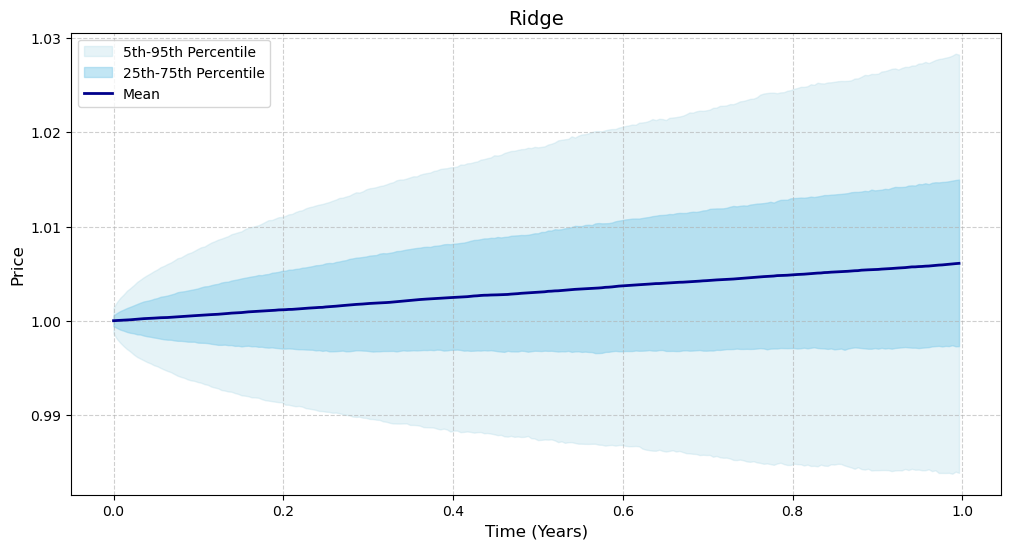

In [27]:
L2_return_np = L2_return.to_numpy()
mu = L2_return_np.mean()
std = np.std(L2_return_np)

mu = np.array([mu])
std = np.array([std])

num_assets = len(mu)
alpha_init = np.repeat(1, num_assets)
time_step = 1.0 / 252
num_periods = 252 
time_points = np.arange(0, 1+time_step, time_step)
num_sim = int(1e4)
w0 = 1

sim_prices = np.exp(np.cumsum(np.random.normal(mu, std, size=(num_sim, num_periods)), axis=1))



# Compute percentiles and mean
percentiles = np.percentile(sim_prices, [5, 25, 50, 75, 95], axis=0)  # 5th, 25th, 50th, 75th, 95th percentiles
mean_prices = np.mean(sim_prices, axis=0)  # Compute the mean at each time step

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the percentiles as filled regions
plt.fill_between(time_points[:-1], percentiles[0, :], percentiles[4, :], color='lightblue', alpha=0.3, label="5th-95th Percentile")
plt.fill_between(time_points[:-1], percentiles[1, :], percentiles[3, :], color='skyblue', alpha=0.5, label="25th-75th Percentile")

# Plot median (50th percentile) and mean
#plt.plot(time_points[:-1], percentiles[2, :], linestyle='--', linewidth=2, color="blue", label="Median (50th Percentile)")
plt.plot(time_points[:-1], mean_prices, linestyle='-', linewidth=2, color="darkblue", label="Mean")

# Formatting
plt.title("Ridge", fontsize=14)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()



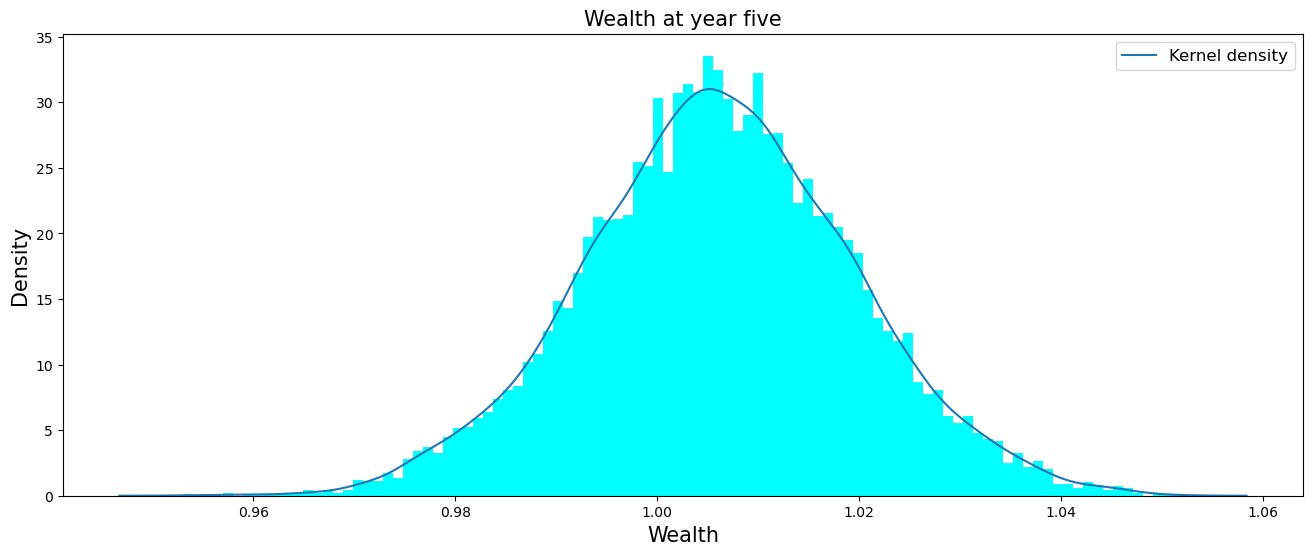

In [28]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16, 6))

ax.hist(sim_prices[:, -1],
        color=['cyan'],
        bins=100, 
        density=True)

sns.kdeplot(sim_prices[:, -1], ax=ax, label="Kernel density")

ax.set_xlabel("Wealth", size=15)
ax.set_ylabel("Density", size=15)
ax.set_title("Wealth at year five", size=15)
#ax.set_ylim([0.5, 3.0])
ax.legend(fontsize=12);

# PC

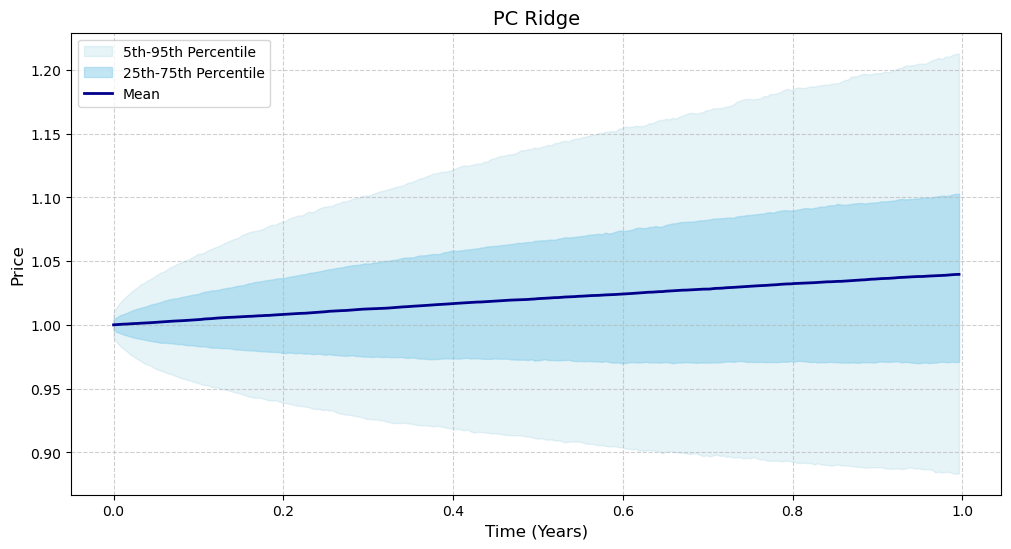

In [29]:
L2_return_PC_np = L2_return_PC.to_numpy()
mu = L2_return_PC_np.mean()
std = np.std(L2_return_PC_np)

mu = np.array([mu])
std = np.array([std])

num_assets = len(mu)
alpha_init = np.repeat(1, num_assets)
time_step = 1.0 / 252
num_periods = 252 
time_points = np.arange(0, 1+time_step, time_step)
num_sim = int(1e4)
w0 = 1

sim_prices = np.exp(np.cumsum(np.random.normal(mu, std, size=(num_sim, num_periods)), axis=1))



# Compute percentiles and mean
percentiles = np.percentile(sim_prices, [5, 25, 50, 75, 95], axis=0)  # 5th, 25th, 50th, 75th, 95th percentiles
mean_prices = np.mean(sim_prices, axis=0)  # Compute the mean at each time step

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the percentiles as filled regions
plt.fill_between(time_points[:-1], percentiles[0, :], percentiles[4, :], color='lightblue', alpha=0.3, label="5th-95th Percentile")
plt.fill_between(time_points[:-1], percentiles[1, :], percentiles[3, :], color='skyblue', alpha=0.5, label="25th-75th Percentile")

# Plot median (50th percentile) and mean
#plt.plot(time_points[:-1], percentiles[2, :], linestyle='--', linewidth=2, color="blue", label="Median (50th Percentile)")
plt.plot(time_points[:-1], mean_prices, linestyle='-', linewidth=2, color="darkblue", label="Mean")

# Formatting
plt.title("PC Ridge", fontsize=14)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()



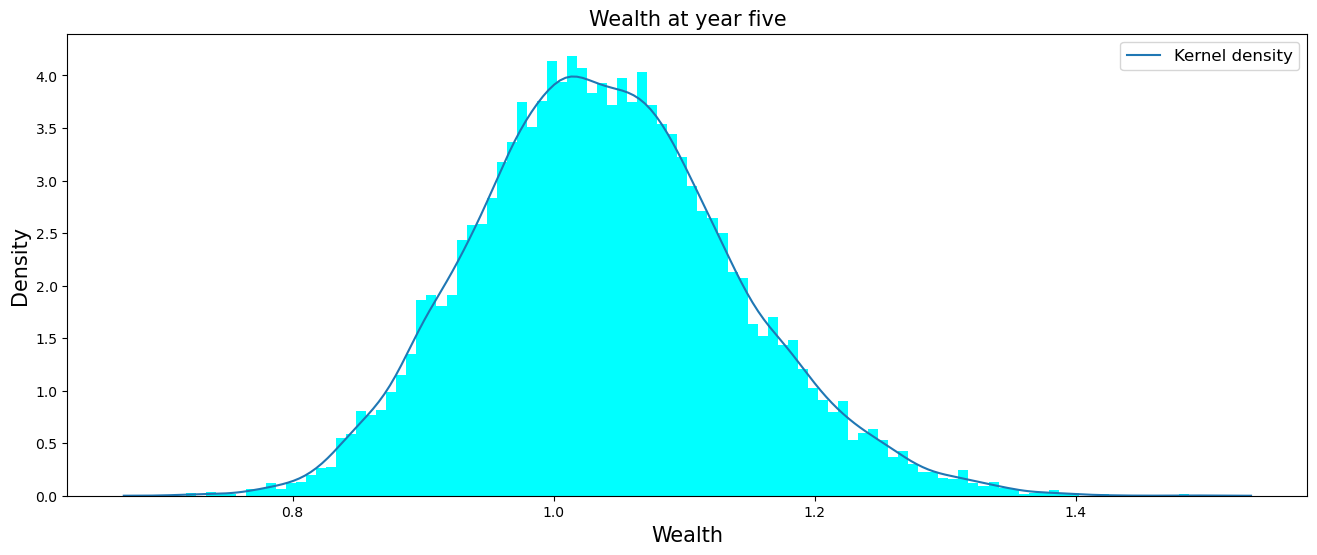

In [30]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.hist(sim_prices[:, -1],
        color=['cyan'],
        bins=100, 
        density=True)

sns.kdeplot(sim_prices[:, -1], ax=ax, label="Kernel density")

ax.set_xlabel("Wealth", size=15)
ax.set_ylabel("Density", size=15)
ax.set_title("Wealth at year five", size=15)
#ax.set_ylim([0.5, 3.0])
ax.legend(fontsize=12);

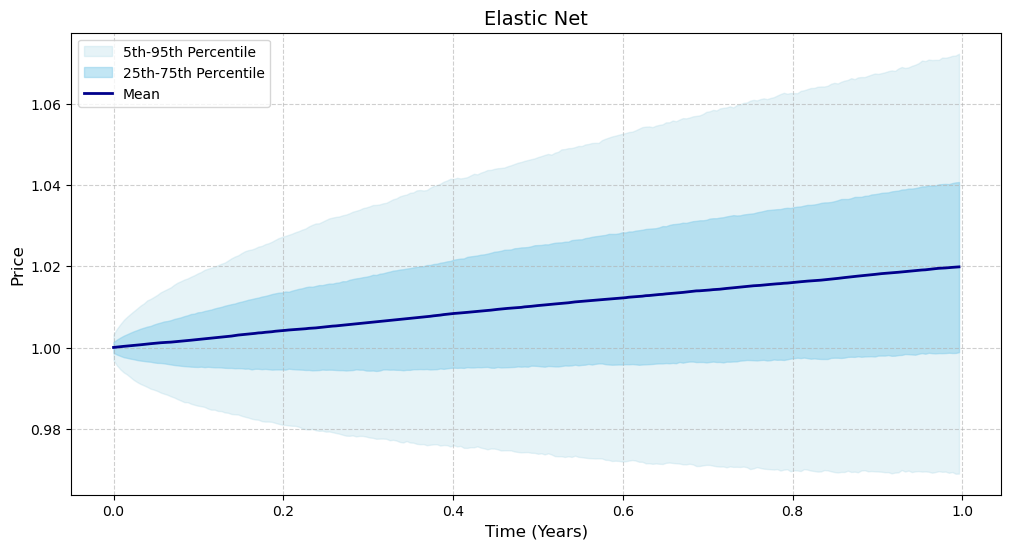

In [43]:
L1L2_return_np = L1L2_returns.to_numpy()
mu = L1L2_return_np.mean()
std = np.std(L1L2_return_np)

mu = np.array([mu])
std = np.array([std])

num_assets = len(mu)
alpha_init = np.repeat(1, num_assets)
time_step = 1.0 / 252
num_periods = 252 
time_points = np.arange(0, 1+time_step, time_step)
num_sim = int(1e4)
w0 = 1

sim_prices = np.exp(np.cumsum(np.random.normal(mu, std, size=(num_sim, num_periods)), axis=1))



# Compute percentiles and mean
percentiles = np.percentile(sim_prices, [5, 25, 50, 75, 95], axis=0)  # 5th, 25th, 50th, 75th, 95th percentiles
mean_prices = np.mean(sim_prices, axis=0)  # Compute the mean at each time step

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the percentiles as filled regions
plt.fill_between(time_points[:-1], percentiles[0, :], percentiles[4, :], color='lightblue', alpha=0.3, label="5th-95th Percentile")
plt.fill_between(time_points[:-1], percentiles[1, :], percentiles[3, :], color='skyblue', alpha=0.5, label="25th-75th Percentile")

# Plot median (50th percentile) and mean
#plt.plot(time_points[:-1], percentiles[2, :], linestyle='--', linewidth=2, color="blue", label="Median (50th Percentile)")
plt.plot(time_points[:-1], mean_prices, linestyle='-', linewidth=2, color="darkblue", label="Mean")

# Formatting
plt.title("Elastic Net", fontsize=14)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()



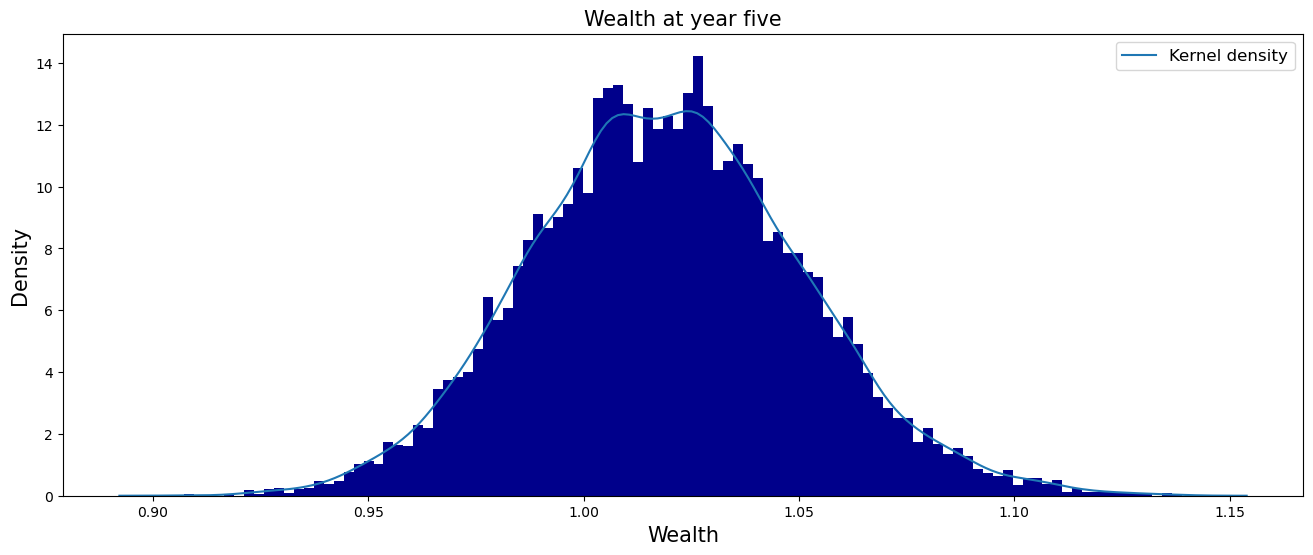

In [32]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.hist(sim_prices[:, -1],
        color=['Darkblue'],
        bins=100, 
        density=True)

sns.kdeplot(sim_prices[:, -1], ax=ax, label="Kernel density")

ax.set_xlabel("Wealth", size=15)
ax.set_ylabel("Density", size=15)
ax.set_title("Wealth at year five", size=15)
#ax.set_ylim([0.5, 3.0])
ax.legend(fontsize=12);

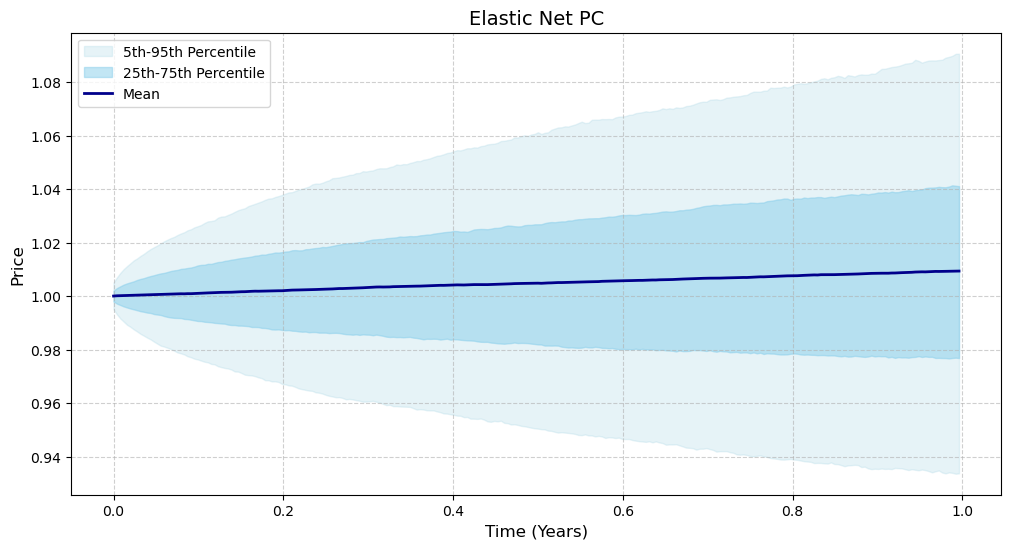

In [33]:
L1L2_return_PC_np = L1L2_returns_PC.to_numpy()
mu = L1L2_return_PC_np.mean()
std = np.std(L1L2_return_PC_np)

mu = np.array([mu])
std = np.array([std])

num_assets = len(mu)
alpha_init = np.repeat(1, num_assets)
time_step = 1.0 / 252
num_periods = 252 
time_points = np.arange(0, 1+time_step, time_step)
num_sim = int(1e4)
w0 = 1

sim_prices = np.exp(np.cumsum(np.random.normal(mu, std, size=(num_sim, num_periods)), axis=1))



# Compute percentiles and mean
percentiles = np.percentile(sim_prices, [5, 25, 50, 75, 95], axis=0)  # 5th, 25th, 50th, 75th, 95th percentiles
mean_prices = np.mean(sim_prices, axis=0)  # Compute the mean at each time step

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the percentiles as filled regions
plt.fill_between(time_points[:-1], percentiles[0, :], percentiles[4, :], color='lightblue', alpha=0.3, label="5th-95th Percentile")
plt.fill_between(time_points[:-1], percentiles[1, :], percentiles[3, :], color='skyblue', alpha=0.5, label="25th-75th Percentile")

# Plot median (50th percentile) and mean
#plt.plot(time_points[:-1], percentiles[2, :], linestyle='--', linewidth=2, color="blue", label="Median (50th Percentile)")
plt.plot(time_points[:-1], mean_prices, linestyle='-', linewidth=2, color="darkblue", label="Mean")

# Formatting
plt.title("Elastic Net PC", fontsize=14)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()



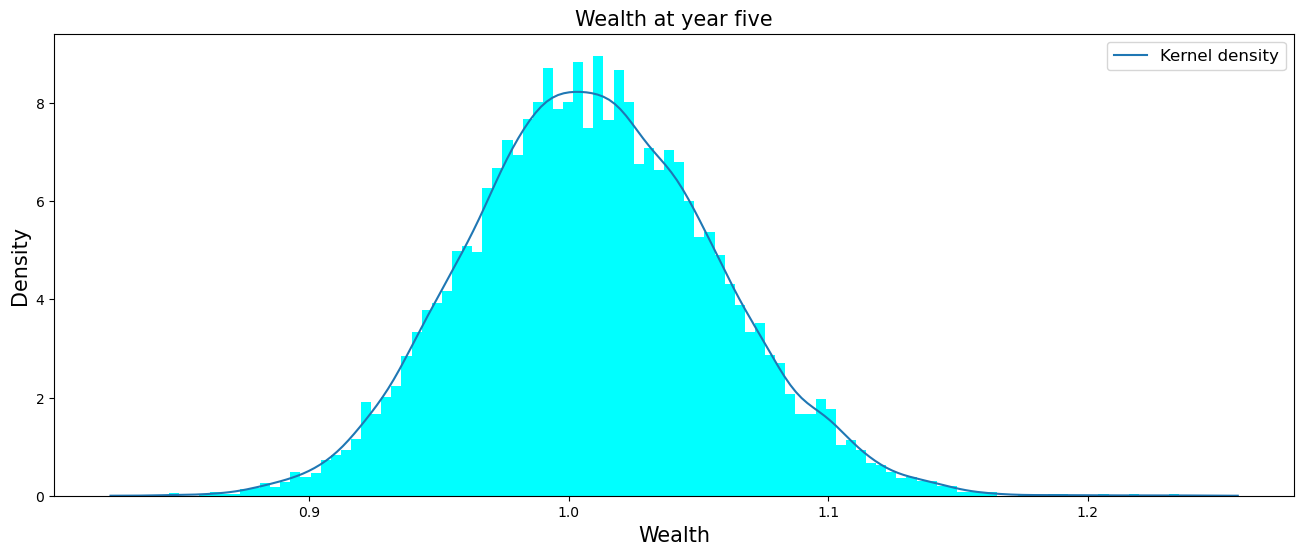

In [34]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.hist(sim_prices[:, -1],
        color=['cyan'],
        bins=100, 
        density=True)

sns.kdeplot(sim_prices[:, -1], ax=ax, label="Kernel density")

ax.set_xlabel("Wealth", size=15)
ax.set_ylabel("Density", size=15)
ax.set_title("Wealth at year five", size=15)
#ax.set_ylim([0.5, 3.0])
ax.legend(fontsize=12);

In [55]:
ff_daily = FamaFrenchReader("12_Industry_Portfolios_Daily", start='1990', end='2024')
ff_daily = ff_daily.read()

# Access the DataFrame
ff_daily = ff_daily[0]
ff_daily = ff_daily.iloc[1:]


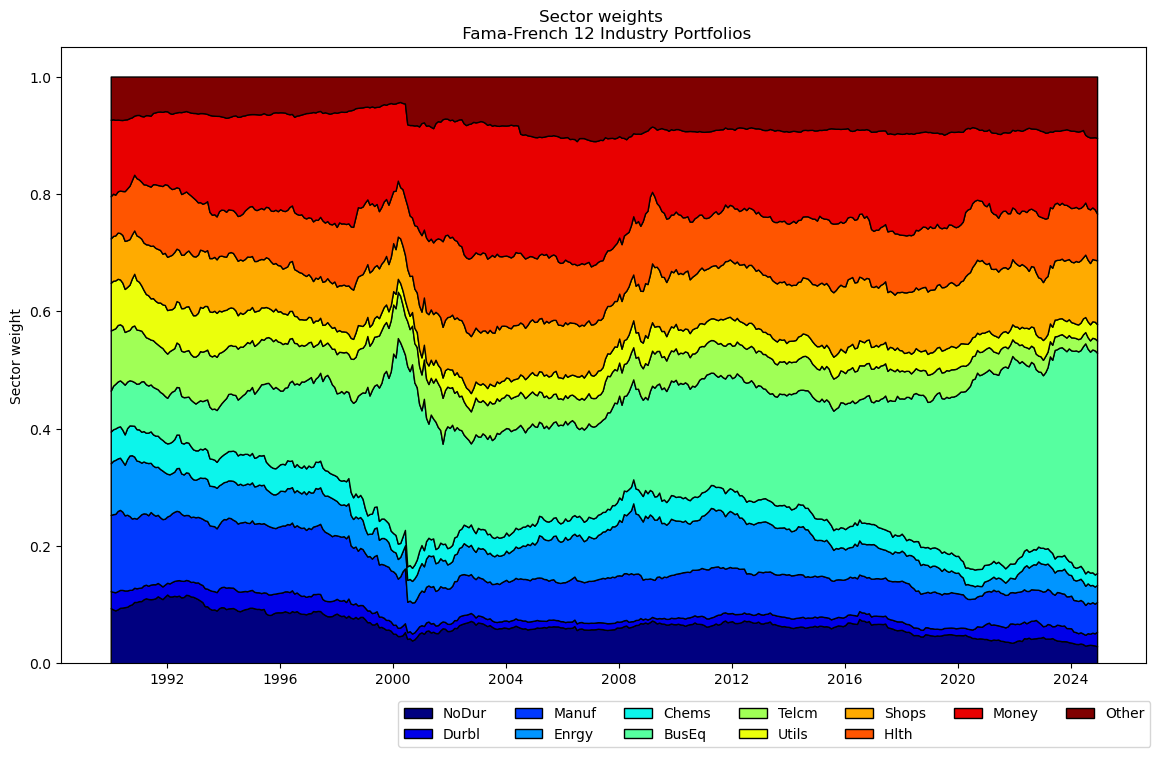

In [38]:
"""
Obtain Fama-French Industry portfolios since 1970
"""

ff_dict = FamaFrenchReader('12_Industry_Portfolios',
                           start='1990-01-01').read()

ff_daily_dict = FamaFrenchReader('12_Industry_Portfolios_Daily',
                                 start='2024-01-01').read()  


# market capitialization for each sector 
df_mc = ff_dict[4] * ff_dict[5]

# total market cap. for each month
total_mc =  df_mc.sum(axis=1)

# relative weights 
df_weights = df_mc.divide(total_mc, axis=0) 

# show weights
df_weights.head()

cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, 12))

fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(df_weights.index.to_timestamp(),
              df_weights.values.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weight')
ax.set_title("Sector weights \n Fama-French 12 Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

In [49]:
ff_daily.shape

(11092, 12)

In [60]:

def SCS_L2est_FF(dates, re, market, freq, anomalies, parameters):
    """
    Computes the L2 shrinkage estimator of the SDF parameters
    based on the method in Kozak, Nagel, and Santosh (2019).
    
    Parameters:
    - dates (pd.Series): time series of dates
    - re (pd.DataFrame): matrix of excess returns time series
    - market (pd.Series): matrix of market's excess returns time series
    - freq (int): number of observations per year
    - anomalies (list): list of anomaly names
    - kwargs: other optional keyword arguments
        * gridsize (int): default=20
        * cvmethod (str): default='CV'
        * kfold (int): default=4
        * objective (str): default='C-S R^2'
        * plot_dof (bool): default=False
        * plot_coefpaths (bool): default=False
        * plot_objective (bool): default=False
        * ... more parameters...
    
    Returns:
    - estimates (dict): structure of estimates
    
    Note: Always cite the paper when using this function.
    """

    # Assign default values
    parameters = {
        'gridsize': 100,
        'method': 'CV',
        'objective': 'CSR2',
        'ignore_scale': False,
        'kfold': 3,
        'oos_test_date': dates.iloc[-100],
        'freq': freq,
        'rotate_PC': True,
        'demarket_conditionally': False,
        'demarket_unconditionally': True,
        'devol_conditionally': False,
        'devol_unconditionally': True,
        'plot_dof': False,
        'plot_coefpaths': True,
        'plot_objective': True,
        'line_width': 1.5,
        'font_size': 10,
        'L2_max_legends': 20,
        'L2_sort_loc': 'opt',
        'L1_log_scale': True,
        'L2_log_scale': True,
        'legend_loc': 'best',
        'results_export': True,
        'show_plot': False
    }

    # Parse config and assign default values
    # parameters = parse_config(parameters, default_config)

    # We usually maximize an objective (e.g., R^2), except for HJ-distance (GLS) and SSE
    if parameters["objective"] in ['GLS', 'SSE']:
        optfunc = min
    else:
        optfunc = max

    # User-friendly names for objectives to use in plots
    mapObj = {
        'CSR2': 'Cross-sectional $R^2$',
        'GLSR2': 'Cross-sectional GLS $R^2$',
        'GLS': 'Residual $SR^2$',
        'SRexpl': 'Explained SR',
        'SSE': 'SDF RMSE',
        'SR': 'Sharpe Ratio',
        'MVU': 'Mean-variance utility'
    }
    parameters["sObjective"] = mapObj[parameters["objective"]]

    # Initialize; compute means, cov, SVD decomposition
    # Testing sample start date
    tT0 = parameters["oos_test_date"]
    re.index = dates.values
    market.index = dates.values

    mkt0 = market.copy()

    # De-market all excess returns 
    if parameters['demarket_conditionally']:  # conditionally
        demarket_ma_window = 10 * parameters['freq']  # use past 3 years to estimate betas

        # Placeholder for custom function `demarkcond`
        r0 = demarketcond(re.iloc[idx_train, :], market.iloc[idx_train], demarket_ma_window)
        idx_train = idx_train[demarket_ma_window:]  # drop NaNs

    elif parameters['demarket_unconditionally']:  # unconditionally

        # Placeholder for custom function `demarket`
        r_train, b_train = demarket(re.loc[:tT0, :], market.loc[:tT0])
        r_test = demarket(re.loc[tT0:, :], market.loc[tT0:], b_train)  # use betas estimated in the training sample
        # check if r_test is a dataframe
        if isinstance(r_test, pd.DataFrame):
            r0 = pd.concat([r_train, r_test], axis=0)
        else:
            r0 = r_train.copy()

    else:
        r0 = re.copy()

    # De-vol all excess returns conditionally if requested
    if parameters['devol_conditionally']:
        devol_ma_window = 22  # use past 22 days to estimate volatilities

        # Placeholder for custom function `devolcond`
        r0, mkt0 = devolcond(r0, market, devol_ma_window)
        idx_train = idx_train[devol_ma_window:]  # drop NaNs

    elif parameters['devol_unconditionally']:  # de-vol unconditionally

        # Normalize so that all returns have the standard deviation of the VW market
        r0 = r0.divide(r0.std(axis=0), axis=1).multiply(market.std())

    # Construct dates, mkt, and returns for train and test sets
    mkt = mkt0.loc[:tT0]
    mkt_test = mkt0.loc[tT0:]

    r_train = r0.loc[:tT0, :]
    r_test = r0.loc[tT0:, :]

    # Length of the training sample
    T, n = r_train.shape
    parameters['T'] = T
    parameters['n'] = n

    # Rotate into PC space if requested and change file suffix
    if parameters.get('rotate_PC', True):
        # Use training sample to form eigenvectors
        cov_matrix = r_train.cov().to_numpy()
        _, _, Q = np.linalg.svd(cov_matrix, full_matrices=True)
        r_train = pd.DataFrame(np.dot(r_train, Q), index=r_train.index, columns=r_train.columns)
        r_test = pd.DataFrame(np.dot(r_test, Q), index=r_test.index, columns=r_test.columns)
        anomalies = ['PC' + str(i) for i in range(1, n + 1)]

    # Compute first and second moments
    X = regcov(r_train)
    y = np.mean(r_train, axis=0)#.reshape(-1, 1)  # making y a column vector
    #X_test = regcov(r_test)  # TODO: test does not have data in it!!
    #y_test = np.mean(r_test, axis=0)#.reshape(-1, 1)  # making y_test a column vector

    # Maximum in-sample SR
    w = np.dot(np.dot(y.T, np.linalg.pinv(X)), y)
    maxSR2 = freq * w

    # Precompute E-V decomposition
    U, D, Q = np.linalg.svd(X)
    X2 = np.dot(np.dot(Q, np.sqrt(np.diag(D))), Q.T)
    d = np.sum(np.diag(D), axis=1)

    # Pre-compute pseudo inverses
    tol = max(X.shape) * np.finfo(float).eps * np.linalg.norm(d, np.inf)
    r1 = np.sum(d > tol) + 1
    Q1 = Q[:, :r1]
    s = d[:r1]
    s2 = 1 / np.sqrt(s)
    s = 1 / s
    Q1 = Q1.T
    Xinv = np.dot(Q1 * s.reshape(1, -1), Q1.T)
    X2inv = np.dot(Q1 * s2.reshape(1, -1), Q1.T)

    # Options
    parameters['xlbl'] = 'Root Expected SR$^2$ (prior), $\\kappa$'
    parameters['Q'] = Q
    parameters['d'] = d
    parameters['Xinv'] = Xinv


    # Functions to map L2pen <-> kappa
    kappa2pen = lambda kappa, T, X, p: p['freq'] * np.trace(X) / T / (kappa ** 2)

    # Find left and right limits
    lr = np.arange(1, 22)  # equivalent of 1:21 in MATLAB
    lm = 1

    z = np.empty((n, len(lr)))
    z.fill(np.nan)

    for i in lr:
        params = parameters.copy()  # Make a copy of p to avoid modifying the original
        params['L2pen'] = kappa2pen(2 ** (i - lm), T, X, parameters)
        z[:, i - 1] = l2est(X, y, params)[0]

    # Coefficient stabilize condition
    mean_val = np.mean(np.abs((z[:, 1:] - z[:, :-1])) / (1 + np.abs(z[:, :-1])), axis=0) > 0.01
    x_rlim = np.nonzero(mean_val)[0]

    # Use the left and right points to define the support and create a finer grid on this support
    x = np.logspace(np.log10(2**x_rlim[-1]), np.log10(0.01), parameters['gridsize'])
    l = [kappa2pen(val, T, X, parameters) for val in x]
    lCV = [val / (1 - 1 / parameters['kfold']) for val in l]  
    nl = len(l)

    # Estimate the L2 model
    params = parameters.copy() # Make a copy of p to avoid modifying the original

    # Create placeholders for outputs
    phi = np.full((n, nl), np.nan)
    se = np.full_like(phi, np.nan)
    objL2 = np.full((nl, 4), np.nan)
    objL2_folds = np.full((nl, params['kfold']), np.nan)  # Assuming params['kfold'] is the number of folds
    MVE = [None] * nl

    for i in range(nl):
        print(i)
        # Estimate parameters at each grid point
        params['L2pen'] = l[i]
        # Note: You need to define the l2est function in Python or provide its MATLAB code for translation
        phi[:, i], _, se[:, i] = l2est(X, y, params, True)

        # Cross validate estimated parameters
        params['L2pen'] = lCV[i]
        # Note: You need to define the cross_validate function in Python or provide its MATLAB code for translation
        objL2[i, :], params, objL2_folds_ = cross_validate(l2est, dates.values, r_train, params)
        objL2_folds[i, :] = objL2_folds_[:, 1] # Python is 0-indexed

        # Store OOS MVE portfolios for each CV run
        MVE[i] = params['cv_MVE']

    cv_idx_test = params['cv_idx_test'] 

    # Effective degrees of freedom
    #df = np.sum(d.reshape(153,1) / (d.reshape(153,1) + np.array(l).reshape(1,100)), axis=0)

    # Optimal L2 model
    
    objL2opt = optfunc(objL2[:, 1])
    if optfunc == max:
        iL2opt = objL2[:, 1].argmax()
    if optfunc == min:
        iL2opt = objL2[:, 1].argmin()
    bL2 = phi[:, iL2opt]
    parameters['bL2'] = bL2
    parameters['R2oos'] = objL2opt
    L2optKappa = x[iL2opt]

    # MVE portfolios for each fold at the optimal level of shrinkage [flatten into single time-series]
    MVEopt = MVE[iL2opt]

    # Return coefficients paths, degrees of freedom, and objective's value
    parameters['coeffsPaths'] = phi
    parameters['objL2_IS'] = objL2[:, 0]
    parameters['objL2_OOS'] = objL2[:, 1]
    z = np.concatenate([MVEopt[key] for key in MVEopt], axis=0)
    parameters['optimal_model_L2'] = {
        'coefficients': bL2,
        'objective': objL2opt,
        'kappa': L2optKappa,
        'SR': np.mean(z) / np.std(z) * np.sqrt(parameters['freq'])
    }
    estimates = parameters

    # df <-> kappa plot
    if parameters['plot_dof']:  # plot degrees of freedom
        plot_dof(df, x, parameters)

    # SDF 2nd moment constraint (L2) coefficients 
    if parameters['plot_coefpaths']:
        # plot coefficients
        plot_L2coefpaths(x, phi, iL2opt, anomalies, 'SDF Coefficient, $b$', parameters)
        # plot t-stats
        plot_L2coefpaths(x, phi/se, iL2opt, anomalies, 'SDF Coefficient $t$-statistic', parameters)

    # L2 Cross-Validation/BIC plot
    if parameters['plot_objective']:
        plot_L2cv(x, objL2, parameters)

    # output table with coefficient & tstats estimates
    table_L2coefs(phi[:, iL2opt], se[:, iL2opt], anomalies, parameters)

    return estimates


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
  Portfolio         b    t_stat
0      PC12 -0.918923  1.822804
1       PC5 -0.805623  1.605250
2      PC10 -0.803989  1.602612
3       PC7  0.538320  1.148162
4       PC8 -0.396061  0.826628
5       PC3 -0.393547  0.806215
6       PC4  0.281012  0.575383
7       PC2  0.258535  0.527727
8       PC6  0.245187  0.512154
9       PC1  0.216679  0.431294


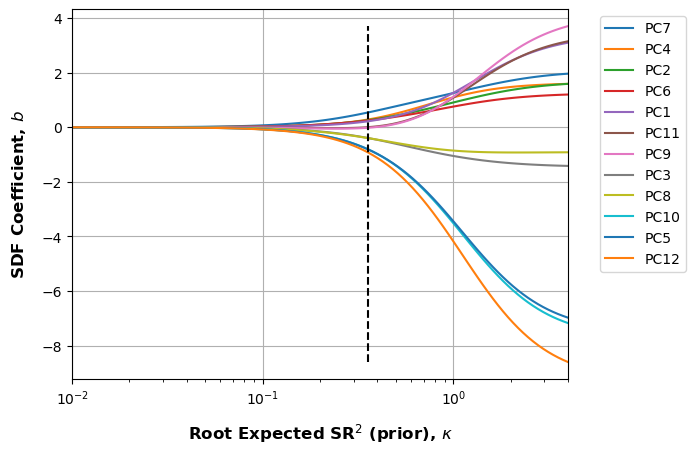

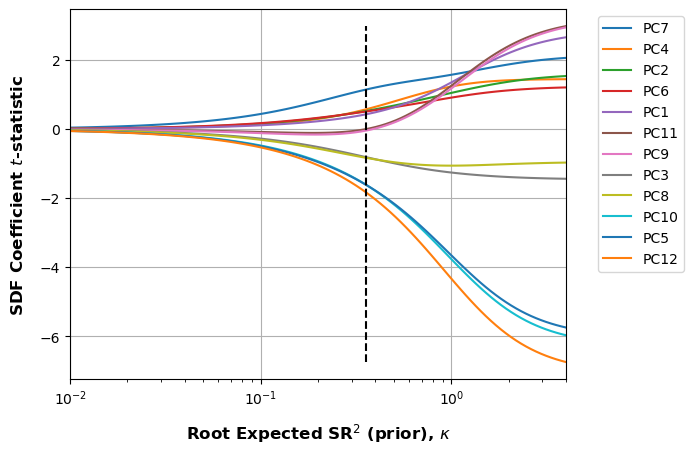

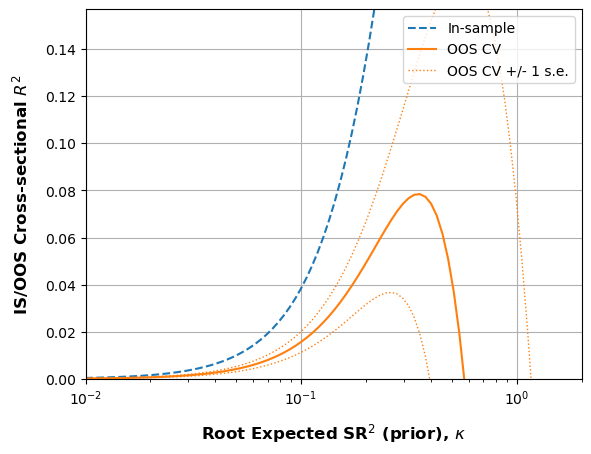

In [61]:
test = SCS_L2est_FF(daily_date_series,ff_daily,spx_daily_ret_squeezed,252, unique_values, {})